# Terrain Classification
### Created by Keenan McConkey 2019.5.17

In [1]:
from __future__ import absolute_import, division, print_function

import pandas as pd

import glob
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from mpl_toolkits.mplot3d import Axes3D
from scipy import signal
from scipy import stats

from datetime import datetime
from decimal import Decimal

import pymrmr
import sklearn

## Part 1 - Importing Datasets

### Part (0) - Functions for Data Import

In [2]:
# Easier to read column names - Convention is different for older datasets
frame_columns = ['X Accel', 'Y Accel', 'Z Accel', 'X Gyro', 'Y Gyro', 'Z Gyro', 'Epoch Time']
std_columns =   ['X Accel', 'Y Accel', 'Z Accel', 'X Gyro', 'Y Gyro', 'Z Gyro', 'Run Time', 'Epoch Time']
data_columns =  ['X Accel', 'Y Accel', 'Z Accel', 'X Gyro', 'Y Gyro', 'Z Gyro']

# Columns not currently used for classification - Usually for phone data
unused_columns = ('LINEAR ACCELERATION X (m/s²)', 'LINEAR ACCELERATION Y (m/s²)', 'LINEAR ACCELERATION Z (m/s²)',
                  'GRAVITY X (m/s²)', 'GRAVITY Y (m/s²)', 'GRAVITY Z (m/s²)', 
                  'MAGNETIC FIELD X (μT)', 'MAGNETIC FIELD Y (μT)', 'MAGNETIC FIELD Z (μT)',
                  'ORIENTATION X (pitch °)', 'ORIENTATION Y (roll °)', 'ORIENTATION Z (azimuth °)',
                  'MagX', 'MagY', 'MagZ')

'''Get columns for given label'''
def get_columns(_label):
    columns = []
    
    # New naming scheme
    if 'Phone' in _label or 'Wheel' in _label or 'Module' in _label:
        columns = std_columns.copy()
    # Old frame data naming scheme
    elif 'Frame' in _label:
        columns = frame_columns.copy()
    else:
        raise Exception('Unknown label')
    
    # For transformed datasets replace time columns with frequency
    if 'FFT' in _label or 'PSD' in _label:
        columns.remove('Epoch Time')
        
        if 'Run Time' in columns:
            columns.remove('Run Time')
        
        columns.append('Frequency')
        
    return columns

In [3]:
# Types of terrain tested and placements on the wheelchair
terrains = ['Concrete', 'Carpet', 'Linoleum', 'Asphalt', 'Sidewalk', 'Grass', 'Gravel']
placements = ['Left', 'Right', 'Middle']
transforms = ['FFT', 'PSDLog', 'PSD']

'''Get the integer terrain value of a given label'''
def get_terrain_num(_label):
    for i, terrain in enumerate(terrains):
        if terrain in _label:
            return i
        
    raise Exception('Unknown terrain')

'''Get the name associated with a terrain integer'''
def get_terrain_name(terrain_num):
    return terrains[terrain_num]

'''Get the placement location name for given label'''
def get_placement(_label):
    for placement in placements:
        if placement in _label:
            return placement
    
    raise Exception('Unknown placement')

def get_transform(_label):
    for transform in transforms:
        if transform in _label:
            return transform
    
    raise Exception('Unkown transform')

### Part (a) - Parsing Data into Pandas

In [4]:
# Find .csv files
raw_datasets = {}
dataset_paths = glob.glob('imu_data/set_full/*.csv')

In [5]:
# Import datasets as an array of Pandas DataFrames
TRIM_START = 2400 # Number of data points to trim from each side (1s = 200 data points)
TRIM_END = 2600
TRIM_OFFSET = 200 # Difference between startup of wheels and frame (1s)
N_DATA_COL = 6 # Number of columns containing directional data

dataset_labels = []

for dataset_path in dataset_paths:
    
    # Parse labels from filenames
    dataset_label = dataset_path.split(' ')[-1].split('/')[-1].split('.')[0]    
    dataset_labels.append(dataset_label)

    # Read from CSV to Pandas
    dataset = pd.read_csv(dataset_path)

    # Drop unused columns
    for to_remove in unused_columns:
        if to_remove in dataset.columns:
            dataset = dataset.drop(to_remove, axis=1)

    # Rename columns to something easier to work with
    dataset.columns = get_columns(dataset_label)

    # Convert timestamps to epoch time in s
    dataset['Epoch Time'] = dataset['Epoch Time'].apply(datetime.strptime, args=("%Y-%m-%d %H:%M:%S:%f",))
    dataset['Epoch Time'] = dataset['Epoch Time'].apply(datetime.timestamp)
    
    # Remove gravitational acceleration from Frame and Middle Phone data
    ## Can't remove from wheel-mounted devices because they rotate over time
    if 'Middle' in dataset_label:
        # Calculate gravity from last 2000 datapoints and subtract from Z Zccel
        ## We need to calculate it manually because device may not be exactly parallel to terrain
        #g_z = dataset.loc[-2000:]['Z Accel'].mean()

        # Using direct 9.81 instead if we assume calibrated to flat surface
        g_z = 9.81
        dataset['Z Accel'] = dataset['Z Accel'].apply(lambda x: x - g_z)

    # Remove dropped bytes - i.e. run times below zero
    #dataset = dataset.drop(dataset.loc[dataset['Run Time'] < 0].index.values.tolist())

    # Trim edges to account for start and end time of 10 s plus some offest
    # Wheels start up about 1 s after the frame module
    if 'Middle' in dataset_label:
        dataset = dataset[TRIM_START + TRIM_OFFSET : -TRIM_END]
    else:
        dataset = dataset[TRIM_START : -TRIM_END]
    
    # Datasets are stored in a dictionary
    raw_datasets.update({dataset_label: dataset})

In [6]:
# List all datasets
#dataset_labels

In [7]:
# Check dataset formatting
raw_datasets['Middle_GrassPowerStraight2_Module'].head()

,X Accel,Y Accel,Z Accel,X Gyro,Y Gyro,Z Gyro,Run Time,Epoch Time
2600,0.000802,-0.002881,0.423396,-0.024162,0.070925,-0.081316,13.004996,1.560899e+09
2601,-0.159646,-0.275882,0.150394,-0.003917,0.093168,-0.077586,13.010887,1.560899e+09
2602,-0.976256,-0.227987,0.126446,-0.013507,0.076652,-0.077986,13.014998,1.560899e+09
2603,-1.084019,0.102488,-0.491399,-0.012308,0.001799,-0.079451,13.020883,1.560899e+09
2604,-1.028940,0.306042,-0.838638,0.014862,-0.034695,-0.093036,13.024995,1.560899e+09


### Part (b) - Visualizing Time Domain Data

In [16]:
'''Plot a single dataset in one direction'''
def plot_one(_datasets, dataset_name, y_column, x_column, xlim=None, ylim=None, save_fig=False):
    plt.clf()
    plt.figure(figsize=(10, 5))
    
    plt.plot(_datasets[dataset_name][x_column], _datasets[dataset_name][y_column])
    #plt.title(dataset_name)
    plt.xlabel(x_column + ' (s)')
    
    if 'Accel' in y_column:
        plt.ylabel(y_column + ' ($m/s^2$)')
    elif 'Gyro' in y_column:
        plt.ylabel(y_column + ' ($rad/s$)')
    else:
        plt.ylabel('Unknown')
    
    if xlim is not None:
        plt.xlim(xlim[0], xlim[1])
    
    if ylim is not None:
        plt.ylim(ylim[0], ylim[1])
    
    # Save figure to png file without plotting
    if save_fig is True:
        save_name = '/home/caris/Wheelchair-Terrain-Classification/imgs/'
        save_name = save_name + y_column.replace(' ', '_') + '_' + dataset_name + '.png'
        plt.savefig(save_name)
    # Just plot without saving
    else:    
        plt.show()

<Figure size 432x288 with 0 Axes>

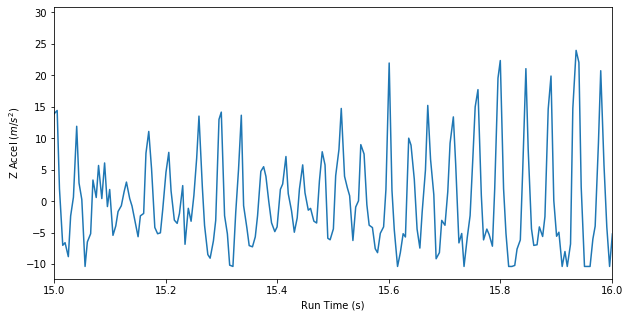

In [18]:
# Test plot
plot_one(raw_datasets, 'Middle_GravelStraight_Module', 'Z Accel', 'Run Time', xlim=(15, 16))

In [19]:
#Plot every dataset Z Accel and save images
#for label in dataset_labels:
#    plot_one(label, 'Z Gyro', 'Run Time', save_fig=True)

In [20]:
'''Compare two Pandas DataFrames by Epoch Time'''
def dataset_compare(dataset1, label1, dataset2, label2, dirn, t_offset=0, y_offset=0):
    plt.clf()
    fig, ax = plt.subplots(figsize=(20, 5))
    
    # Plot data with given y and t offsetson first dataset
    ax.plot(dataset1[label1]['Epoch Time'].apply(lambda t: t + t_offset), 
            dataset1[label1][dirn].apply(lambda y: y + y_offset), label=label1)
    ax.plot(dataset2[label2]['Epoch Time'], 
            dataset2[label2][dirn], label=label2)
    
    ax.set_xlabel('Epoch Time ($s$)')
    ax.set_ylabel(dirn)
    ax.set_title(dirn + ' for ' + label1 + ' and ' + label2)
    
    # Plot offset info
    offset_text = 'Offsets\n'
    offset_text += ': t={}'.format(t_offset) + ', ' + 'y={}'.format(y_offset)
    ax.text(0.05, 0.05, s=offset_text, 
            horizontalalignment='left', verticalalignment='bottom', transform=ax.transAxes)
    
    ax.legend()
    plt.show()

<Figure size 432x288 with 0 Axes>

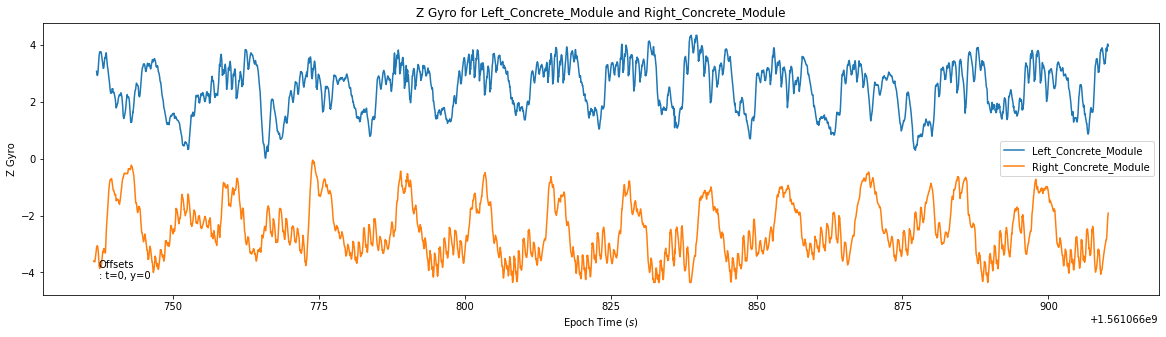

In [21]:
# Compare Z Gyro data for each wheel in the same dataset
dataset_compare(raw_datasets, 'Left_Concrete_Module',
                raw_datasets, 'Right_Concrete_Module', 
                dirn='Z Gyro')

In [22]:
'''Plot given x and y axes for every Pandas DataFrame in given array of datasets'''
def plot_all(_datasets, x_axis, y_axis, windowed=False, win_num=0, take_row=False):
    plt.clf()
    
    n_axes = len(_datasets)
    odd_axes = n_axes % 2 == 1
    
    rows = int((n_axes + 1) / 2)
    
    # Scale approriately
    if (odd_axes):
        fig = plt.figure(figsize=(n_axes*5, n_axes*3))          
    else:
        fig = plt.figure(figsize=(n_axes*5, n_axes*2))
    
    # Grid of subplots
    gs = gridspec.GridSpec(rows, 2)
        
    axes = []
    row, col = 0, 0
    
    for i, (label, dataset) in enumerate(_datasets.items()):
        # Take a whole row if odd num of axes
        if (i == n_axes-1 and odd_axes and take_row): 
            axes.append(fig.add_subplot(gs[row, :]))
        else:
            axes.append(fig.add_subplot(gs[row, col]))
        
        # Plot on new subplot
        if (windowed):
            axes[i].plot(dataset[win_num][x_axis], dataset[win_num][y_axis])
        else:
            axes[i].plot(dataset[x_axis], dataset[y_axis])
        
        axes[i].set_title(label)
        axes[i].set_xlabel(x_axis + ' (s)')
        axes[i].set_ylabel(y_axis + ' ($m/s^2$)')
        
        # Only go two columns wide
        col += 1
        if (col == 2):
            row += 1
            col = 0
        
    plt.subplots_adjust(hspace=0.35, wspace=0.15)
    plt.show()

<Figure size 432x288 with 0 Axes>

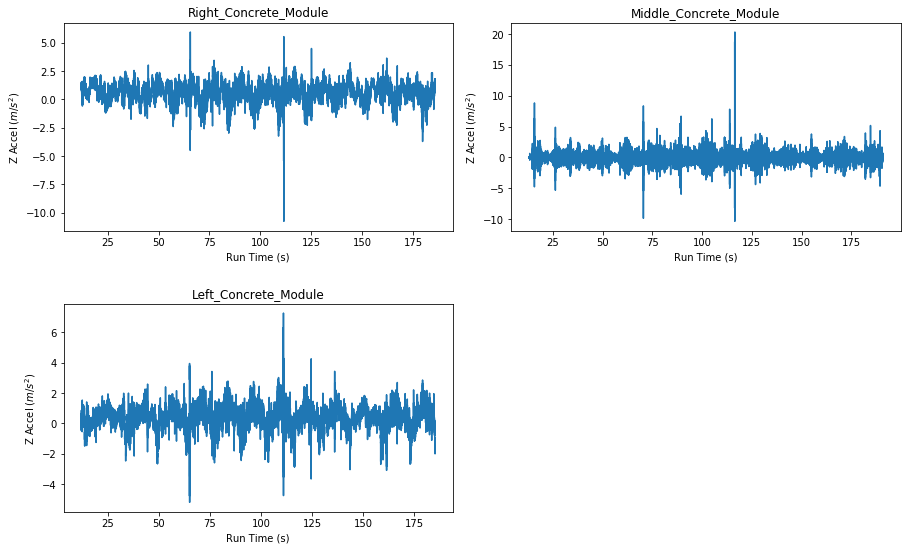

In [24]:
# Plot Z Accel of some datasets
datasets_to_plot = {label: dataset for label, dataset in raw_datasets.items() if 'Concrete_' in label}
plot_all(datasets_to_plot, x_axis='Run Time', y_axis='Z Accel')

### Part (c) - Converting Between Pandas and Numpy

In [41]:
'''Convert array of Pandas DataFrames to array of 2D Numpy array'''
def pd_to_np(pd_datasets, windowed=False):
    np_datasets = {}
    
    for label, dataset in pd_datasets.items():
        np_dataset = []
        
        # Return passed datasets if they are already NumPy ndarrays
        if type(dataset) is np.ndarray:
            print('Already a numpy array!')
            return pd_datasets
        
        # If windowed, convert individual windows to Pandas
        if (windowed):
            for window in dataset:
                np_dataset.append(window.as_matrix()) 
        else:
            np_dataset = dataset.as_matrix()
        
        np_datasets.update({label: np_dataset})
        
    return np_datasets

In [38]:
'''Convert array of 2D Numpy arrays to Pandas Data Frames'''
def np_to_pd(np_datasets, windowed=False):
    pd_datasets = {}
    
    for label, dataset in np_datasets.items():
        pd_dataset = []
        
        # Return passed datasets if they are already Pandas dataframes
        if type(dataset) is pd.DataFrame:
            print('Already a dataframe!')
            return np_datasets
        
        # Use correct column names
        new_columns = get_columns(label)
            
        # If windowed, convert individual windows to Pandas
        if (windowed):
            for window in dataset:
                pd_dataset.append(pd.DataFrame(data=window, columns=new_columns))
                
        else:
            pd_dataset = pd.DataFrame(data=dataset, columns=new_columns)
            
        pd_datasets.update({label: pd_dataset})
    
    return pd_datasets

In [47]:
# Convert to NumPy
raw_datasets = pd_to_np(raw_datasets)

/home/caris/anaconda2/envs/keenanm/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [43]:
# Run to convert back to Pandas
#raw_datasets = np_to_pd(raw_datasets)

In [44]:
# Check if its constructed correctly
print('Number of datasets: {}'.format(len(raw_datasets)))
print('Shape of first dataset: {}'.format(raw_datasets[dataset_labels[0]].shape))

Number of datasets: 96
Shape of first dataset: (1496, 8)


Structure of data:

`Terrain Dataset Dictionary -> NP Array with Row = Datapoint, Col = Direction | Time`

## Part 2 - Filtering

**Nominally set to 30 % of Nyquist Freq**

In [54]:
'''Get frequencies for given label'''
def get_frequencies(label):
    # Sampling frequency varies for different devices (old datasets only)
    if ('Frame' in label): # Old naming convention used 'Frame'
        f_samp = 100 # Sampling frequency
        f_low = 15 # Low pass cutoff frequency
        f_high = 1 # High pass cutoff frequency
    else:
        f_samp = 200 # Sampling frequency
        f_low = 30 # Low pass cutoff frequency
        f_high = 1 # High pass cutoff frequency
        
    return f_samp, f_low, f_high

### Part (a) - Butterworth Filtering

Butterworth filters can be high-pass/low-pass/bandpass, and attempt to have maximally flat frequency response in bandpass.

Changing the *cutoff frequency* of the filter affects the smoothness of the graph and amount of ringing. 

Changing the *order* of the filter can have significant effects on smoothness depending on the cutoff frequency. 

<Figure size 432x288 with 0 Axes>

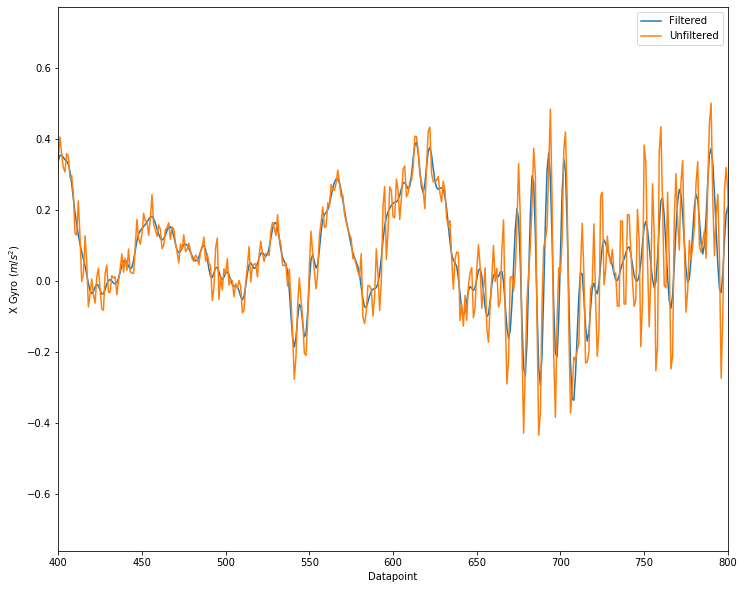

In [55]:
# Filtered datasets dictionary
datasets = {}

for label, raw_dataset in raw_datasets.items():
    
    # Sampling rates are not consistent across all datasets
    f_samp, f_low, f_high = get_frequencies(label)
    
    # Get normalized frequencies
    w_low = f_low / (f_samp / 2) 
    w_high = f_high / (f_samp / 2)

    # Get Butterworth filter parameters
    b_butter, a_butter = signal.butter(N=4, Wn=w_low, btype='low')
    
    # Filter all the data columns
    dataset = np.copy(raw_dataset)
    for i in range(N_DATA_COL):
        dataset[:, i] = signal.filtfilt(b_butter, a_butter, raw_dataset[:, i])
        
    datasets.update({label: dataset})

# Compare filtered and unfiltered
plt.clf()
plt.figure(figsize=(12, 10))
plt.plot(datasets[dataset_labels[0]][:, 3], label='Filtered')
plt.plot(raw_datasets[dataset_labels[0]][:, 3], label='Unfiltered')
plt.xlim(400, 800)
plt.legend()
plt.xlabel('Datapoint')
plt.ylabel('X Gyro ($m/s^2$)')
plt.show()

In [56]:
## Check construction
print('Num filtered datasets: {}'.format(len(datasets)))
print('Shape of first filtered dataset: {}'.format(datasets[dataset_labels[0]].shape))

Num filtered datasets: 96
Shape of first filtered dataset: (1496, 8)


In [57]:
# Verify we can convert back to Pandas
np_to_pd(datasets, windowed=False)[dataset_labels[0]].head()

,X Accel,Y Accel,Z Accel,X Gyro,Y Gyro,Z Gyro,Run Time,Epoch Time
0,-10.211538,10.538171,-1.475410,-0.062442,-0.091988,4.34627,12.000000,1.561068e+09
1,-8.090178,9.357774,-0.328796,-0.112439,-0.110025,4.34627,12.004864,1.561068e+09
2,-6.651989,8.708308,0.486959,-0.138571,-0.121934,4.34627,12.009984,1.561068e+09
3,-6.131313,8.814129,0.832130,-0.131519,-0.125343,4.34627,12.014848,1.561068e+09
4,-6.234239,9.500662,0.799030,-0.101403,-0.121584,4.34627,12.019968,1.561068e+09


<Figure size 432x288 with 0 Axes>

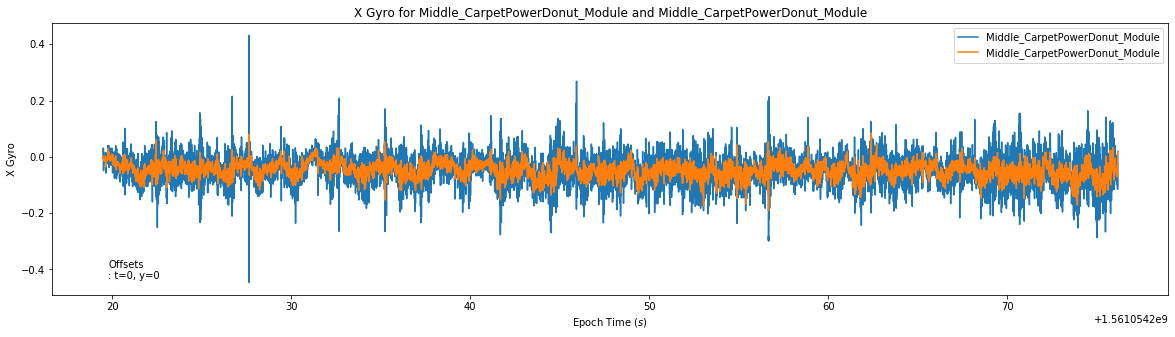

In [58]:
# Compare filtered and unfiltered data
dataset_compare(np_to_pd(raw_datasets), dataset_labels[1], 
                np_to_pd(datasets), dataset_labels[1], 'X Gyro')

In [ ]:
# Test plot - Acceleration maximum is cutoff!
plot_one(np_to_pd(datasets), 'Middle_CarpetStraight_Module', 'Z Accel', 'Run Time', xlim=(16, 17))

## Part 3 - Time Windows

### Part (a) - Finding an optimal time window

Strategy is to start with a large time window and work down. 

Plot classification accuracy and time vs window size and find an optimal size

### Part (b) - Creating Time Windowed Data

In [61]:
# TODO: Create an array of different window sizes, taking out the desired array so don't have to rename

WINDOW_SIZE = 200 # Divide by F_SAMP to get window size in seconds
datasets_windowed = {}

#raw_datasets = {label: dataset for label, dataset in raw_datasets.items() if 'Middle' in label}
# Trim excess datapoints, then split into windows
for label, dataset in datasets.items():   
    n_windows = int(len(dataset) / WINDOW_SIZE)
    n_points = n_windows*WINDOW_SIZE
    
    dataset_windowed = np.resize(dataset, (n_points, dataset.shape[1]))
    dataset_windowed = np.split(dataset_windowed, n_windows, axis=0)
    
    datasets_windowed.update({label: dataset_windowed})

In [62]:
# Check if its constructed correctly
print('Num windowed datasets: {}'.format(len(datasets_windowed)))
print('Num of windows in first dataset: {}'.format(len(datasets_windowed[dataset_labels[0]])))
print('Shape of individual window: {}'.format(datasets_windowed[dataset_labels[0]][0].shape))

Num windowed datasets: 96
Num of windows in first dataset: 7
Shape of individual window: (200, 8)


Structure of windowed data:

`Terrain Dataset Dictionary -> Window List -> NP Array with Row = Datapoint, Col = Direction | Time`

In [63]:
# Try out pandas conversion again
np_to_pd(datasets_windowed, windowed=True)[dataset_labels[0]][0].tail()

,X Accel,Y Accel,Z Accel,X Gyro,Y Gyro,Z Gyro,Run Time,Epoch Time
195,-0.545870,11.445027,1.291865,0.043509,-0.277694,4.34627,12.974848,1.561068e+09
196,0.133796,12.092423,1.246516,0.034968,-0.300345,4.34627,12.979968,1.561068e+09
197,0.942100,12.395941,1.012272,0.015522,-0.307957,4.34627,12.984832,1.561068e+09
198,1.835090,12.245813,0.529093,-0.004191,-0.299723,4.34627,12.989952,1.561068e+09
199,2.719915,11.858499,-0.006406,-0.011141,-0.284252,4.34627,12.995072,1.561068e+09


<Figure size 432x288 with 0 Axes>

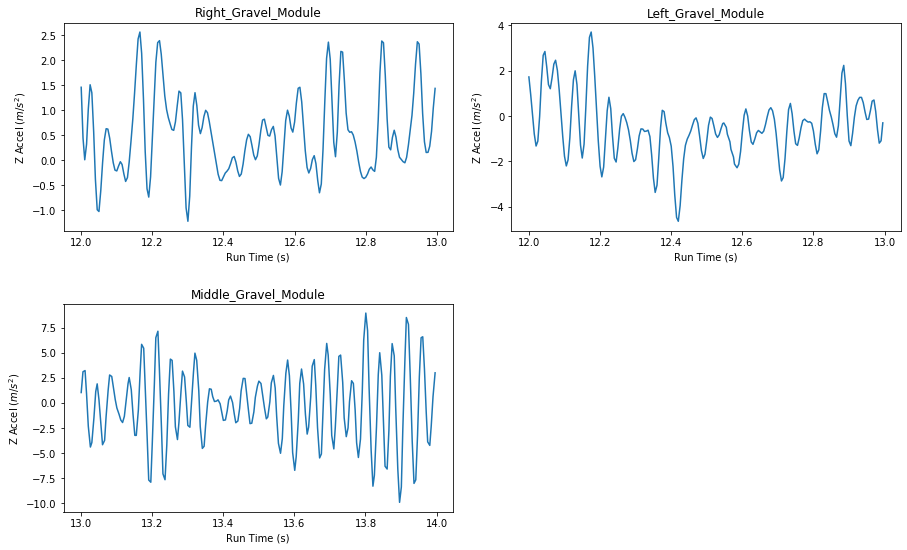

In [67]:
# Plot the first time window
datasets_to_plot = {label: dataset for label, dataset in datasets_windowed.items() if 'Gravel_' in label}
plot_all(np_to_pd(datasets_to_plot, windowed=True), 
         x_axis='Run Time', y_axis='Z Accel', windowed=True, win_num=0)

## Part 4 - Transforms

In [68]:
'''Plot tranform of given direction and window of a windowed dataset dictionary'''
def plot_set_transforms(datasets_transformed, dirn, win_num, transform_name):
    plt.clf()
    plt.figure(figsize=(12, 8))
    
    # Plot all the FFTs in one figure overlaid
    for label, dataset in datasets_transformed.items():
        plt.plot(dataset[win_num][:, -1], dataset[win_num][:, dirn], 
                 label=label)
    plt.legend()

    plt.xlabel('Frequency ($Hz$)')
    if (transform_name == 'FFT'):
        plt.ylabel('Amplitude (Normalized to Window Size)')
    elif (transform_name == 'PSD'):
        plt.ylabel('Amplitude (Log-Scaled)')

    plt.title(transform_name +' of ' + data_columns[dirn] + 
              ', Window {}, Window Size = {} Data Points'.format(win_num, WINDOW_SIZE))
    plt.show()

### Part (a) - FFT

In [69]:
datasets_fft = {}

# Find the FFT of each column of each data window of each dataset
for label, dataset in datasets_windowed.items():
    dataset_fft = []
    
    for window in dataset:
        # Number of frequency bins is half of window size to trim the symmetric higher frequencies
        n_bins = int(WINDOW_SIZE / 2)
        window_fft = np.zeros((n_bins, N_DATA_COL))
        
        # Sampling frequency dependent on device
        f_samp, f_low, f_high = get_frequencies(label)
        
        for i in range(N_DATA_COL):
            # FFT is normalized to window size, to ensure consistency between different size choices
            window_fft[:, i] = np.resize(np.abs(np.divide(np.fft.fft(window[:, i]), WINDOW_SIZE)), n_bins)
            
        # Get positive frequency bins for given FFT parameters
        freq_col = np.transpose([np.resize(np.fft.fftfreq(WINDOW_SIZE, 1 / f_samp), n_bins)])
        
        # Append the frequency column
        window_fft = np.append(window_fft, freq_col, axis=1)
        dataset_fft.append(window_fft)
        
    datasets_fft.update({label + 'FFT': dataset_fft})

In [70]:
# Check again if its constructed correctly
print('Num of FFT\'d windowed datasets: {}'.format(len(datasets_fft)))
print('Num of FFT\'d windows in first dataset: {}'.format(len(datasets_fft[dataset_labels[4]+'FFT'])))
print('Shape of FFT\'d individual window: {}'.format(datasets_fft[dataset_labels[4]+'FFT'][0].shape))

# Pandas conversion
np_to_pd(datasets_fft, windowed=True)[dataset_labels[0]+'FFT'][0].head()

Num of FFT'd windowed datasets: 96
Num of FFT'd windows in first dataset: 27
Shape of FFT'd individual window: (100, 7)


,X Accel,Y Accel,Z Accel,X Gyro,Y Gyro,Z Gyro,Frequency
0,1.495574,4.043801,0.358526,0.030966,0.169773,4.346270e+00,0.0
1,4.179453,4.735616,0.235641,0.026982,0.006769,0.000000e+00,1.0
2,1.767255,1.087667,0.124277,0.025037,0.015279,0.000000e+00,2.0
3,0.630182,0.194876,0.073600,0.023843,0.017672,0.000000e+00,3.0
4,0.379807,0.200651,0.078054,0.002187,0.024727,2.090350e-16,4.0


<Figure size 432x288 with 0 Axes>

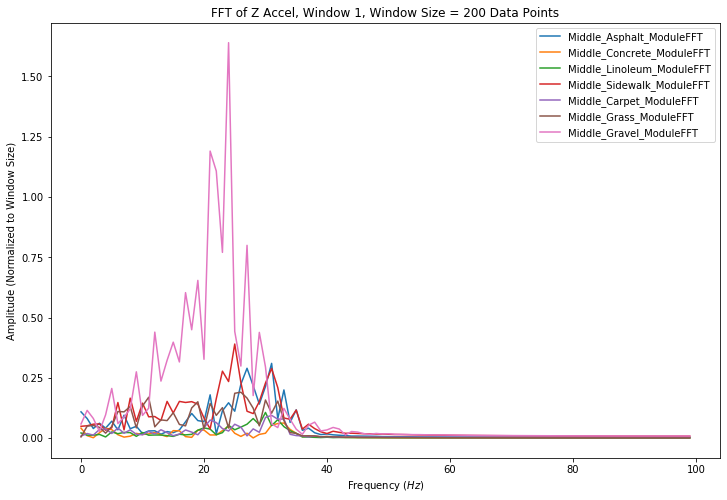

In [71]:
# Plot Z Accel of 0th window, Frame only
ffts_to_plot = {label: dataset for label, dataset in datasets_fft.items() if 'Middle' in label and 'Power' not in label and 'Straight' not in label and 'Donut' not in label}
plot_set_transforms(ffts_to_plot, win_num=1, dirn=2, transform_name='FFT')

The Butterworth cutoff frequency is pretty noticeable. Theres not an easily recognizable cutoff from the unfiltered data.

**The number of frequency bins is dependent on window size, and it seems to affect amplitude too.**

<Figure size 432x288 with 0 Axes>

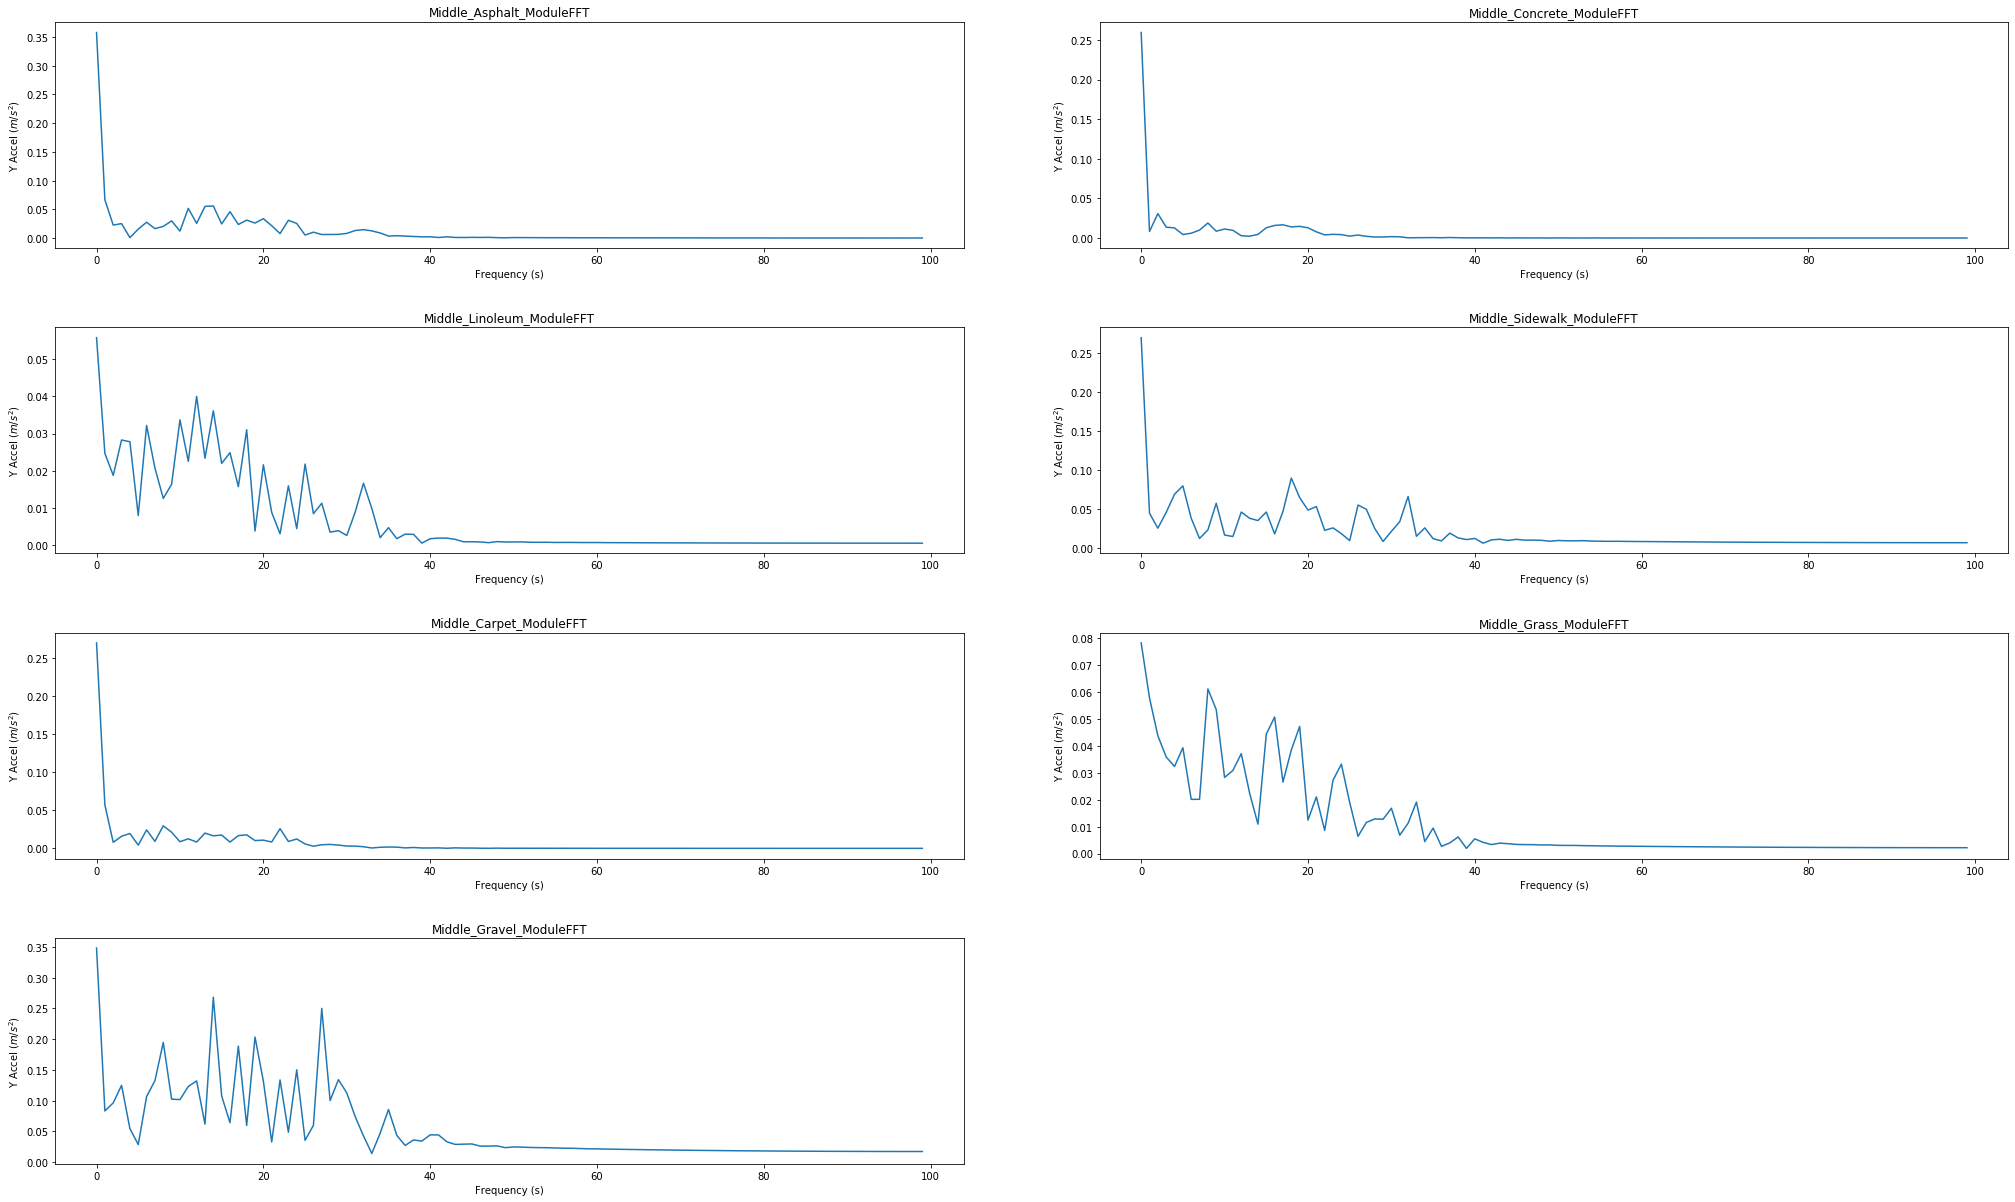

In [72]:
# Plot all the Frame FFTs for 0th window
plot_all(np_to_pd(ffts_to_plot, windowed=True), x_axis='Frequency', y_axis='Y Accel', windowed=True)

### Part (b) - PSD

In [73]:
datasets_psd = {}
datasets_psd_log = {}

# Find the PSD and log(PSD) of each column of each data window of each dataset
for label, dataset in datasets_windowed.items():
    dataset_psd = []
    dataset_psd_log = []
    
    for window in dataset:
        # Number of frequency bins is half of window size to trim the symmetric higher frequencies
        n_bins = int(WINDOW_SIZE / 2)
        window_psd = np.zeros((n_bins, N_DATA_COL))
        window_psd_log = np.zeros((n_bins, N_DATA_COL))
        
        f_samp, f_low, f_high = get_frequencies(label)
        
        # Calculate PSD for each axes
        for i in range(N_DATA_COL):
            # Normalized PSD - Returns frequencies and power density
            freq, Pxx = signal.periodogram(window[:, i], f_samp)
            window_psd[:, i] = np.resize(Pxx[1:], n_bins)
            
            #window_psd_log[:, i] = np.copy(window_psd[:, i])
            
            # Calculate log10 of PSD, replacing points where PSD = 0
            for j in range(len(window_psd[:, i])):
                if (window_psd[j, i] == 0):
                    window_psd_log[j, i] = 0
                else:
                    window_psd_log[j, i] = np.log10(window_psd[j, i])
            
        # Append freq column
        freq_col = np.transpose([freq[:-1]])
        window_psd = np.append(window_psd, freq_col, axis=1)
        window_psd_log = np.append(window_psd_log, freq_col, axis=1)
        
        dataset_psd.append(window_psd)
        dataset_psd_log.append(window_psd_log)
        
    datasets_psd.update({label + 'PSD': dataset_psd})
    datasets_psd_log.update({label +'PSDLog': dataset_psd_log})

In [74]:
# Check again if its constructed correctly
print('Num PSD\'d windowed datasets: {}'.format(len(datasets_psd)))
print('Num of PSD\'d windows in first dataset: {}'.format(len(datasets_psd[dataset_labels[0]+'PSD'])))
print('Shape of PSD\'d individual window: {}'.format(datasets_psd[dataset_labels[0]+'PSD'][0].shape))

Num PSD'd windowed datasets: 96
Num of PSD'd windows in first dataset: 7
Shape of PSD'd individual window: (100, 7)


<Figure size 432x288 with 0 Axes>

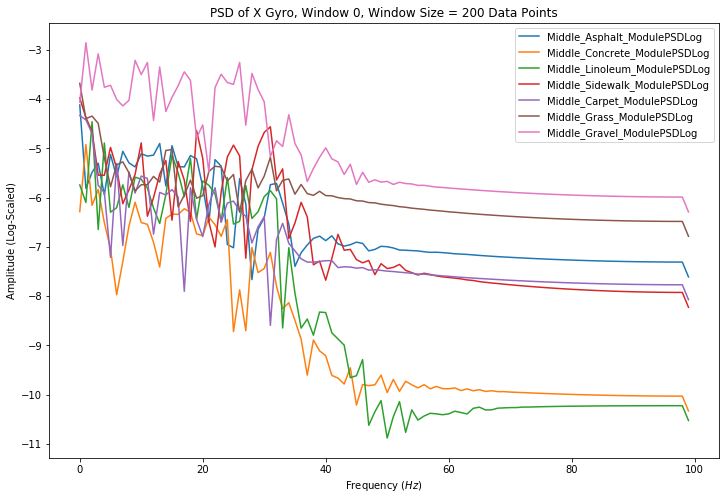

In [76]:
# Plot Z Accel of 0th window
psds_to_plot = {label: dataset for label, dataset in datasets_psd_log.items() if 'Middle' in label and 'Power' not in label and 'Straight' not in label and 'Donut' not in label}
plot_set_transforms(psds_to_plot, win_num=0, dirn=3, transform_name='PSD')

<Figure size 432x288 with 0 Axes>

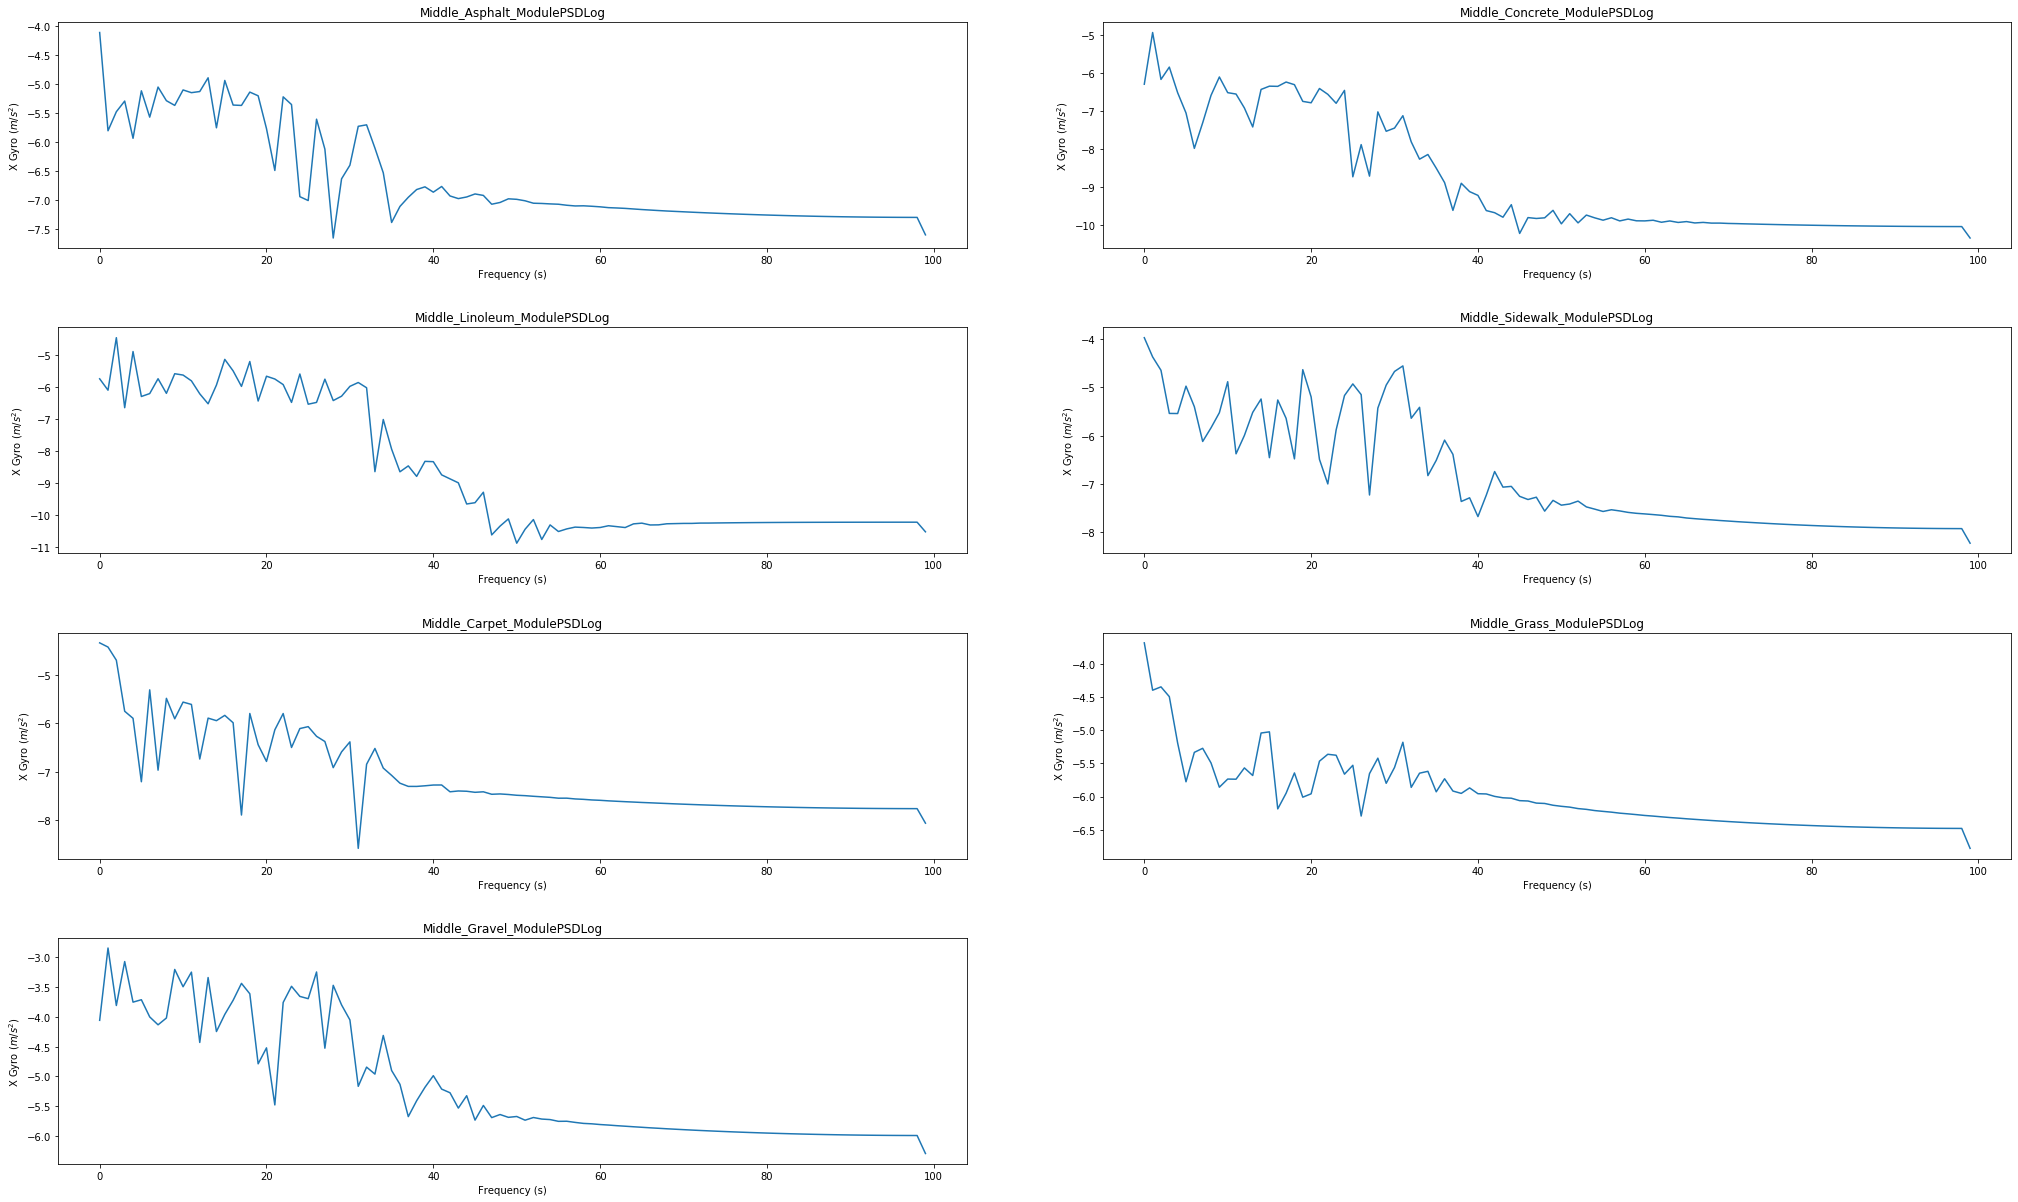

In [77]:
# Plot all PSDs of Z Accel for 0th window
plot_all(np_to_pd(psds_to_plot, windowed=True), x_axis='Frequency', y_axis='X Gyro', windowed=True)

Note that at this point, data is stored like:

`Labelled Terrain Dataset -> Time Window -> 2D NumPy Array Col = Dirn | Frequency)`

### Part (c) - 3D Visualization

In [78]:
'''Plot the set transforms in 3d'''
# TODO: Convert to bar graphs for better representation
def plot_transforms_3d(datasets_transformed, win_num, dirn, transform_name):
    plt.clf()
    fig = plt.figure(figsize=(10, 8))
    ax = fig.gca(projection='3d')
    
    # Specific to FFT or PSD
    if (transform_name == 'FFT'):
        ax.set_zlim(0, 2)
        ax.set_zlabel('Amplitude (Normalized to Window Size)')
    elif (transform_name == 'PSD'):
        ax.set_zlim(-20, 10)
        ax.set_zlabel('Amplitude (Log-Scaled)')
    
    # Change y axis to correspond with whats being plotted
    n_datasets = len(datasets_transformed)
    ax.set_ylim(0, n_datasets)
    subset = np.arange(0, n_datasets, dtype=int)
    ax.set_yticks(np.add(subset, 1))
    
    ax.set_xlabel('Frequency ($Hz$)')
    ax.set_title(transform_name + ' of ' + data_columns[dirn] + 
                 ', Window {}, Window Size = {} Data Points'.format(win_num, WINDOW_SIZE))
        
    # Plot each dataset FFT
    for i, (label, dataset) in enumerate(datasets_transformed.items()):
        ax.plot(xs=dataset[win_num][:, -1], ys=dataset[win_num][:, dirn],
                zs=i+1, zdir='y', label=get_terrain_name(get_terrain_num(label)))
    
    ax.legend()
    plt.show()

<Figure size 432x288 with 0 Axes>

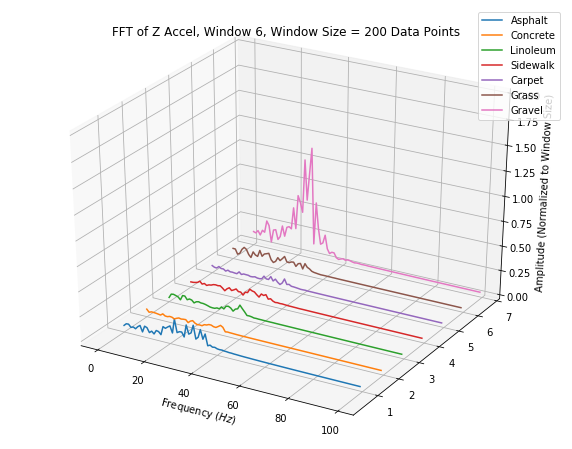

In [83]:
# Plot 3d Z Accel FFT of 0th window
ffts_to_plot = {label: dataset for label, dataset in datasets_fft.items() if 'Middle' in label and 'Power' not in label and 'Straight' not in label and 'Donut' not in label}
plot_transforms_3d(ffts_to_plot, win_num=6, dirn=2, transform_name='FFT')

<Figure size 432x288 with 0 Axes>

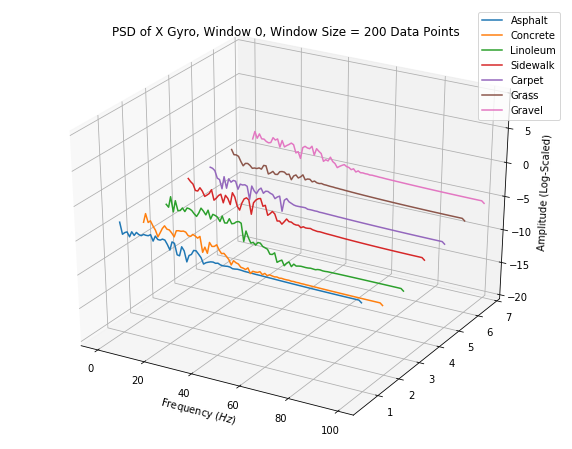

In [85]:
# Plot 3d Z Accel PSD of 0th window
psds_to_plot = {label: dataset for label, dataset in datasets_psd_log.items() if 'Middle' in label and 'Power' not in label and 'Straight' not in label and 'Donut' not in label}
plot_transforms_3d(psds_to_plot, win_num=0, dirn=3, transform_name='PSD')

### Part (d) - Spectograms

In [86]:
'''Plot a spectogram of data'''
def plot_spectogram(set_label, dirn, size=WINDOW_SIZE):
    # Get sampling frequency for label
    f_samp, f_low, f_high = get_frequencies(set_label)
    
    plt.clf()
    plt.figure(figsize=(12, 8))
    
    # Compute spectogram directly using time series data
    plt.specgram(datasets[set_label][:, dirn], NFFT=size, Fs=f_samp)
    plt.title('Spectrogram of {} for {}'.format(data_columns[dirn], set_label))
    plt.xlabel('Data Window')
    plt.xticks(label=np.arange(0, len(datasets_windowed[set_label])))
    plt.ylabel('Frequency ($Hz$)')
    
    plt.show()

<Figure size 432x288 with 0 Axes>

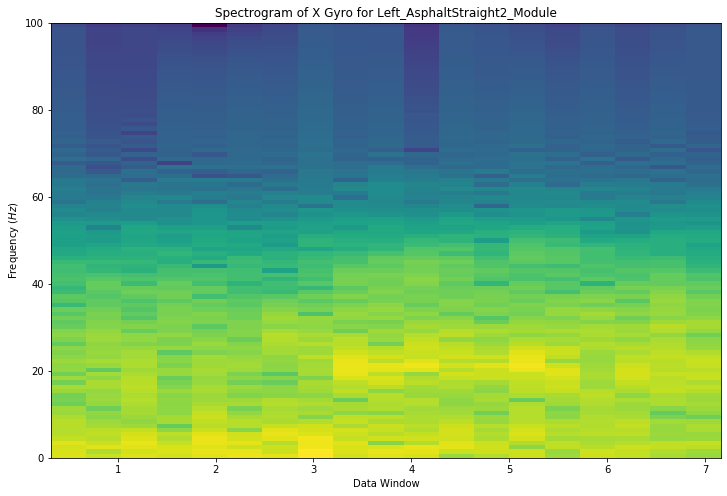

In [88]:
# X Accel
plot_spectogram(dataset_labels[0], dirn=3, size=WINDOW_SIZE)

## Part 5 - Feature Extraction

Structure of feature data:

`Terrain Dataset Dictionary -> Direction Dictionary -> Pandas Array with Row = Window #, Col = Feature`

In [89]:
# Feature extraction functions

EPSILON = 0.00001
'''L2 norm of an array'''
def l2norm(array):
    return np.linalg.norm(array, ord=2)

'''Correlation of an array with itself'''
def autocorr(array):
    return np.correlate(array, array)[0]

'''Root mean squared of an array'''
def rms(array):
    return np.sqrt(np.mean(array ** 2))

'''Zero crossing rate of an array as a fraction of total size of array'''
def zcr(array):
    # Locations where array > 0, put -1 and 1 for rising/falling,
    # divide by total datapoints
    return len(np.nonzero(np.diff(array > 0))[0]) / len(array)

'''Mean square frequency'''
def msf(freqs, psd_amps):
    num = np.sum(np.multiply(np.resize(freq, len(psd_amps)), np.power(psd_amps, 2)))
    denom = np.sum(psd_amps)
    
    # In case zero amplitude transform is ecountered
    if denom <= EPSILON:
        return EPSILON
    
    return np.divide(num, denom)

'''Root mean square frequency'''
def rmsf(freqs, psd_amps):
    return np.sqrt(msf(freqs, psd_amps))

'''Frequency center'''
def fc(freqs, psd_amps):
    num = np.sum(np.multiply(np.resize(freq, len(psd_amps)), psd_amps))
    denom = np.sum(psd_amps)
    
    # In case zero amplitude transform is ecountered
    if denom <= EPSILON:
        return EPSILON
    
    return np.divide(num, denom)

'''Variance frequency'''
def vf(freqs, psd_amps):
    return msf(freqs, psd_amps) - fc(freqs, psd_amps) ** 2

'''Root variance frequency'''
def rvf(freqs, psd_amps):
    return np.sqrt(msf(freqs, psd_amps))

In [90]:
'''Extract given features from everything in dataset'''
def feature_all(features, datasets, regular=True):
    datasets_feat = {}
    
    # Calculate features for each window of each column of each dataset
    for label, dataset in datasets.items():
        directions = {}
        
        # Loop over data columns
        for i, direction in enumerate(get_columns(label)[:N_DATA_COL]):
            feats = {}
            
            if (regular):
                '''Execute a function over all windows'''
                def function_all_windows(function):
                    feat_in_window = []
                    
                    for window in dataset:
                        feat_in_window.append(function(window[:, i]))
                    
                    return feat_in_window
                    
            else:
                '''Alternate defintion for frequency functions'''
                def function_all_windows(function):
                    feat_in_window = []
                    
                    for window in dataset:
                        feat_in_window.append(function(window[:, -1], window[:, i]))
                    
                    return feat_in_window
                    
                    
            # Execute every function over all windows    
            for feat_name, feat_func in features.items():
                feats.update({feat_name: function_all_windows(feat_func)})
            
            directions.update({direction: pd.DataFrame.from_dict(feats)})

        datasets_feat.update({label.replace('PSD', ''): directions})
    
    return datasets_feat

In [91]:
'''Plot a feature on all terrains for each time window'''
def plot_set_features(datasets_feat, dirn, feat_name, placement_name, ylim=None, xlim=None):
    plt.clf()
    plt.figure(figsize=(10,8))
    
    for label, dataset in datasets_feat.items():
        plt.plot(dataset[dirn][feat_name], label=label)
        
    if ylim is not None:
        plt.ylim(ylim[0], ylim[1])
    if xlim is not None:
        plt.xlim(xlim[0], xlim[1])
    
    plt.ylabel(feat_name)
    plt.xlabel('Window #')
    plt.title(placement_name + ' ' + dirn + ', Window Size = {} Data Points'.format(WINDOW_SIZE))
    plt.legend()
    plt.show()

### Part (a) - Time Domain Features

In [92]:
# Time domain feature function names and actual names
time_features = {'Mean': np.mean, 'Std Dev': np.std,  'L2 Norm': l2norm, 'Autocorrelation': autocorr, 
                 'Max': np.amax, 'Min' : np.amin, 'Root Mean Squared': rms, 'Zero Crossing Rate': zcr, 
                 'Skew': stats.skew, 'Excess Kurtosis': stats.kurtosis} 

# Create array of features of each window for each dataset and direction
datasets_feat_time = feature_all(time_features, datasets_windowed)

In [93]:
# Check if its constructed correctly and print some info
print('Num datasets: {}'.format(len(datasets_feat_time)))
print('Num directions: {}'.format(len(datasets_feat_time[dataset_labels[0]])))
print('Shape of first dataset first direction: {}'.format(datasets_feat_time[dataset_labels[0]]['X Gyro'].shape))

Num datasets: 96
Num directions: 6
Shape of first dataset first direction: (7, 10)


<Figure size 432x288 with 0 Axes>

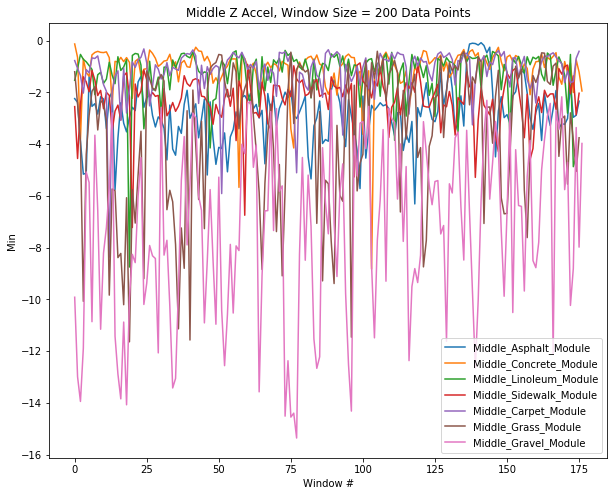

In [96]:
# Plot Min of frame Z Accel
feat_datasets_to_plot = {label: dataset for label, dataset in datasets_feat_time.items() if 'Middle' in label in label and 'Power' not in label and 'Straight' not in label and 'Donut' not in label}
plot_set_features(feat_datasets_to_plot, dirn='Z Accel', feat_name='Min', placement_name='Middle')

<Figure size 432x288 with 0 Axes>

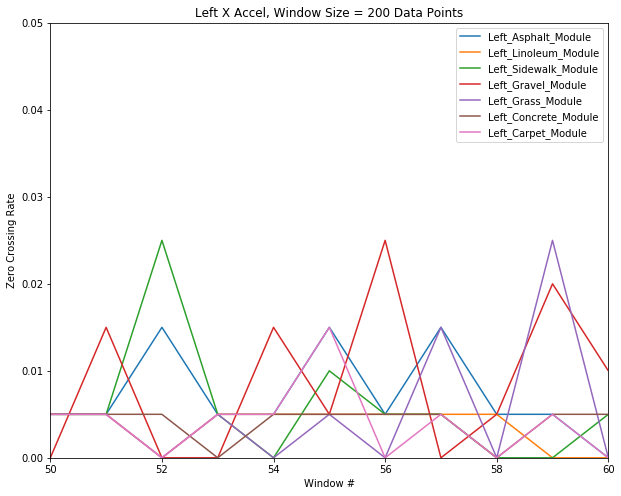

In [97]:
# Plot ZCR of Left Wheel X Accel
feat_datasets_to_plot = {label: dataset for label, dataset in datasets_feat_time.items() if 'Left' in label in label and 'Power' not in label and 'Straight' not in label and 'Donut' not in label}
plot_set_features(feat_datasets_to_plot, dirn='X Accel', feat_name='Zero Crossing Rate', placement_name='Left', ylim=(0, 0.05), xlim=(50, 60))

### Part (b) - Frequency Domain Features

In [98]:
# Time domain feature function names and actual names
freq_features = {'Mean Square Frequency': msf, 'Root Mean Square Frequency': rmsf, 'Frequency Center': fc, 
                 'Variance Frequency': vf, 'Root Variance Frequency': rvf}

# Calculate features for each window of each column of each dataset
# Create array of features of each window for each dataset and direction
datasets_feat_freq = feature_all(freq_features, datasets_psd, regular=False)

In [99]:
# Check if its constructed correctly and print some info
print('Num datasets: {}'.format(len(datasets_feat_freq)))
print('Num directions: {}'.format(len(datasets_feat_freq[dataset_labels[0]])))
print('Shape of one direction: {}'.format(datasets_feat_freq[dataset_labels[0]]['X Gyro'].shape))

Num datasets: 96
Num directions: 6
Shape of one direction: (7, 5)


<Figure size 432x288 with 0 Axes>

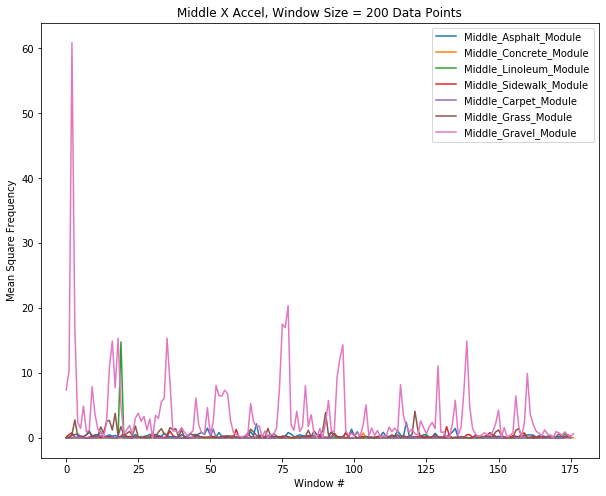

In [100]:
# Plot RVF of Z Accel
feat_datasets_to_plot = {label: feature for label, feature in datasets_feat_freq.items() if 'Middle' in label and 'Power' not in label and 'Straight' not in label and 'Donut' not in label }
plot_set_features(feat_datasets_to_plot, dirn='X Accel', feat_name='Mean Square Frequency', placement_name='Middle')

**Since Z Gyro data is often out of range on old datasets, possible to get PSD of zero which results in NaN values**

## Part 6 - Standardization, Columning, and Combining Datasets

In [101]:
# Convert transformed data to Pandas
datasets_fft = np_to_pd(datasets_fft, windowed=True)
datasets_psd_log = np_to_pd(datasets_psd_log, windowed=True)

In [102]:
# Confirm formatting
datasets_psd_log[dataset_labels[0]+'PSDLog'][1].head()

,X Accel,Y Accel,Z Accel,X Gyro,Y Gyro,Z Gyro,Frequency
0,1.639467,1.457305,-1.280437,-3.563971,-3.884514,0.00000,0.0
1,0.674341,0.949093,-1.351955,-2.754066,-3.008838,0.00000,1.0
2,-0.645029,0.072057,-1.366393,-2.920915,-2.928831,0.00000,2.0
3,-0.560760,-0.186111,-2.169260,-4.152569,-4.340367,-62.56438,3.0
4,-0.958780,-0.390568,-2.058758,-3.121649,-3.427248,0.00000,4.0


In [103]:
# Add time and freq features together
datasets_feat = {}

for label, dataset in datasets_feat_time.items():
    dataset_feat = {}
    
    for dirn_label, dirn_df in dataset.items():
        new_df = dirn_df.join(datasets_feat_freq[label][dirn_label], how='outer')
        dataset_feat.update({dirn_label: new_df})
    
    datasets_feat.update({label: dataset_feat})

In [104]:
# Confirm formatting
datasets_feat['Middle_Carpet_Module']['Y Accel'].head()

,Mean,Std Dev,L2 Norm,Autocorrelation,Max,Min,Root Mean Squared,Zero Crossing Rate,Skew,Excess Kurtosis,Mean Square Frequency,Root Mean Square Frequency,Frequency Center,Variance Frequency,Root Variance Frequency
0,0.270183,0.137117,4.284852,18.359956,0.595263,-0.137680,0.302985,0.020,-0.361008,0.107268,0.006064,0.077875,7.677572,-58.939048,0.077875
1,0.047322,0.152812,2.262343,5.118197,0.427978,-0.539708,0.159972,0.140,-0.312431,0.961817,0.017933,0.133915,13.305898,-177.028982,0.133915
2,-0.030111,0.202285,2.892266,8.365204,0.615711,-0.679003,0.204514,0.155,-0.073848,0.934790,0.025563,0.159883,11.231440,-126.119690,0.159883
3,-0.102921,0.281240,4.235289,17.937670,0.866170,-1.032747,0.299480,0.145,-0.173725,2.139644,0.053791,0.231929,12.103700,-146.445766,0.231929
4,-0.320814,0.271594,5.944486,35.336908,0.312953,-0.936515,0.420339,0.070,0.148558,-0.494390,0.047132,0.217100,10.235262,-104.713461,0.217100


### Part (a) - Standardization

Standardize each feature to mean 0 and standard deviation 1. This will make PCA and classification easier.

In [105]:
'''Normalize already featured datasets'''
def normalize_datasets(datasets, windowed=False):
    # Normalization function
    from sklearn.preprocessing import scale
    
    datasets_norm = {}
    
    # Go through windowed data (transforms) or dictionary data (features)
    for label, dataset in datasets.items():
        if windowed:
            dataset_norm = []
            for window_df in dataset:
                window_df = window_df.dropna()
                dataset_norm.append(window_df.apply(scale))
        else:
            dataset_norm = {}
            for dirn_label, dirn_df in dataset.items():
                dirn_df = dirn_df.dropna()
                dataset_norm.update({dirn_label: dirn_df.apply(sklearn.preprocessing.scale)})
        
        datasets_norm.update({label: dataset_norm})
    
    return datasets_norm

In [107]:
# So we can remove infinites
pd.set_option('use_inf_as_na', True)

datasets_feat_norm = normalize_datasets(datasets_feat)
datasets_fft_norm = normalize_datasets(datasets_fft, windowed=True)
datasets_psd_norm = normalize_datasets(datasets_psd_log, windowed=True)

/home/caris/anaconda2/envs/keenanm/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/home/caris/anaconda2/envs/keenanm/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/home/caris/anaconda2/envs/keenanm/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/home/caris/anaconda2/envs/keenanm/lib/python3.6/site-packages/sklearn

<Figure size 432x288 with 0 Axes>

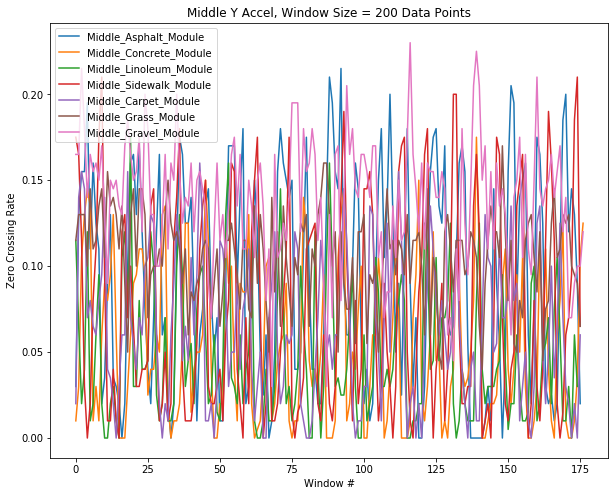

In [116]:
# Plot normalized features
feat_datasets_to_plot = {label: dataset for label, dataset in datasets_feat_time.items() if 'Middle' in label in label and 'Power' not in label and 'Straight' not in label and 'Donut' not in label}
plot_set_features(feat_datasets_to_plot, dirn='Y Accel', feat_name='Zero Crossing Rate', placement_name='Middle')

/home/caris/anaconda2/envs/keenanm/lib/python3.6/site-packages/ipykernel_launcher.py:16: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  app.launch_new_instance()


<Figure size 432x288 with 0 Axes>

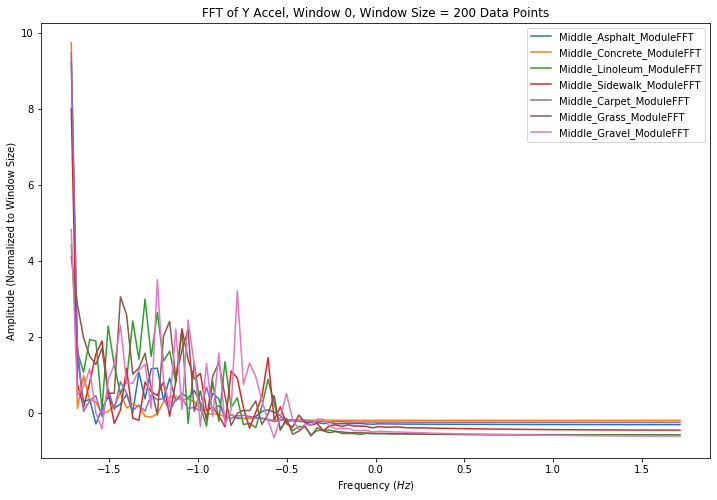

In [117]:
# Plot normalized fft
ffts_to_plot = {label: dataset for label, dataset in datasets_fft_norm.items() if 'Middle' in label and 'Straight' not in label and 'Donut' not in label and 'Power' not in label}
plot_set_transforms(pd_to_np(ffts_to_plot, windowed=True), dirn=1, win_num=0, transform_name='FFT')

### Part (b) - Columning Data

Combine IMU data from each direction into single dataframes with columns for each feature in each direction

#### Part (i) - Extracted Featured Data

In [108]:
'''Append a tag to the end of every column name of a dataframe'''
def append_all_columns(columns, append_tag):
    new_columns = []
    
    for column in columns:
        new_columns.append(column + ' ' + append_tag)
    
    return new_columns

In [109]:
'''Combined directions of a featured dataset'''
def combine_columns(datasets):
    datasets_combined = {}
    
    for label, dataset in datasets.items():
        # Get labels array of first column
        df_combined = pd.DataFrame()
        
        # Append direction name to feature name and combine everything in one frame
        for dirn_label, dirn_df in dataset.items():
            df_copy = pd.DataFrame(dirn_df)
            
            # Add direction and placement tags
            df_copy.columns = append_all_columns(dirn_df.columns, dirn_label)
            df_copy.columns = append_all_columns(dirn_df.columns, get_placement(label))
            
            df_combined = df_combined.join(dirn_df, how='outer')
        
        datasets_combined.update({label: df_combined})
    
    return datasets_combined

In [110]:
# Take frame data and combine directions
datasets_feat_columned = combine_columns(datasets_feat_norm)

# Check dataset
datasets_feat_columned[dataset_labels[3]].head()

,Mean X Accel Left,Std Dev X Accel Left,L2 Norm X Accel Left,Autocorrelation X Accel Left,Max X Accel Left,Min X Accel Left,Root Mean Squared X Accel Left,Zero Crossing Rate X Accel Left,Skew X Accel Left,Excess Kurtosis X Accel Left,...,Min Z Gyro Left,Root Mean Squared Z Gyro Left,Zero Crossing Rate Z Gyro Left,Skew Z Gyro Left,Excess Kurtosis Z Gyro Left,Mean Square Frequency Z Gyro Left,Root Mean Square Frequency Z Gyro Left,Frequency Center Z Gyro Left,Variance Frequency Z Gyro Left,Root Variance Frequency Z Gyro Left
0,0.838862,0.422116,-0.449888,-0.629128,0.679750,-0.245103,-0.449888,-0.153033,-0.931411,-0.139754,...,1.223473,0.912698,-0.181345,-0.573053,0.006152,0.002859,0.323534,0.709481,-0.293478,0.323534
1,-1.027302,0.133996,0.612475,0.604574,-0.359325,-0.793876,0.612475,3.336127,0.983991,-0.324290,...,0.684049,0.673911,-0.181345,-1.316079,0.326517,-0.146984,0.110448,-0.731742,0.568536,0.110448
2,0.979817,0.160207,-0.503257,-0.682336,1.037303,0.350229,-0.503257,-0.153033,-1.064456,0.357127,...,0.611864,0.713296,-0.181345,0.130736,-0.444984,-0.535520,-0.695268,-0.601128,0.536711,-0.695268
3,-1.109066,0.050305,0.738752,0.773320,-0.310036,-1.581247,0.738752,-0.153033,1.254015,1.375368,...,1.221173,1.102364,-0.181345,-0.813888,-0.171463,-0.561614,-0.785935,-0.803237,0.581532,-0.785935
4,1.297383,-0.383820,-0.334604,-0.511328,0.749621,0.763540,-0.334604,1.591547,-1.554646,1.944746,...,0.981756,0.888699,-0.181345,0.231574,-0.446294,-0.538628,-0.705450,-0.892470,0.594269,-0.705450


#### Part (ii) - Transformed Data

In [111]:
'''Combined direction columns for transformed data'''
def combine_transform_columns(datasets):
    combined_datasets = {}
    
    for label, dataset in datasets.items():
        combined_windows = []
        
        for window in dataset:
            window_as_row = pd.DataFrame()
            
            # Turn each window 2D dataframe into a single row dataframe
            for row in window.iterrows():
                for data_column in data_columns:
                    combined_column_name = data_column + ' {} Hz'.format(round(row[1]['Frequency'], 0))
                    combined_column_name += ' ' + get_transform(label) + ' ' + get_placement(label)
                    window_as_row.insert(0, combined_column_name, [row[1][data_column]])
            
            combined_windows.append(window_as_row)
        
        # Combine all the single row dataframes into one dataframe
        combined_datasets.update({label: pd.concat(combined_windows, ignore_index=True)})
    
    return combined_datasets

In [112]:
datasets_fft_columned = combine_transform_columns(datasets_fft)

In [113]:
datasets_psd_log_columned = combine_transform_columns(datasets_psd_log)

In [114]:
# Check FFT data
datasets_fft_columned[dataset_labels[0] + 'FFT']

,Z Gyro 99.0 Hz FFT Left,Y Gyro 99.0 Hz FFT Left,X Gyro 99.0 Hz FFT Left,Z Accel 99.0 Hz FFT Left,Y Accel 99.0 Hz FFT Left,X Accel 99.0 Hz FFT Left,Z Gyro 98.0 Hz FFT Left,Y Gyro 98.0 Hz FFT Left,X Gyro 98.0 Hz FFT Left,Z Accel 98.0 Hz FFT Left,...,X Gyro 1.0 Hz FFT Left,Z Accel 1.0 Hz FFT Left,Y Accel 1.0 Hz FFT Left,X Accel 1.0 Hz FFT Left,Z Gyro 0.0 Hz FFT Left,Y Gyro 0.0 Hz FFT Left,X Gyro 0.0 Hz FFT Left,Z Accel 0.0 Hz FFT Left,Y Accel 0.0 Hz FFT Left,X Accel 0.0 Hz FFT Left
0,0.0,0.000486,0.000060,0.004626,0.001099,0.036306,0.0,0.000486,0.000060,0.004628,...,0.026982,0.235641,4.735616,4.179453,4.34627,0.169773,0.030966,0.358526,4.043801,1.495574
1,0.0,0.000026,0.000840,0.001342,0.036111,0.011735,0.0,0.000026,0.000841,0.001343,...,0.011682,0.161907,3.785626,4.668944,4.34627,0.193343,0.042078,0.280251,3.130092,0.824492
2,0.0,0.001241,0.000271,0.004422,0.005297,0.039259,0.0,0.001241,0.000272,0.004424,...,0.018850,0.188307,4.669960,3.979699,4.34627,0.163762,0.076062,0.289803,0.646928,0.063404
3,0.0,0.001335,0.000003,0.005420,0.034503,0.000461,0.0,0.001336,0.000003,0.005422,...,0.061990,0.339700,4.070943,4.930253,4.34627,0.194380,0.079758,0.081412,1.870189,2.671725
4,0.0,0.000413,0.000335,0.002498,0.009197,0.026754,0.0,0.000414,0.000335,0.002499,...,0.004285,0.055694,5.083951,4.133551,4.34627,0.238498,0.010124,0.438945,3.325673,1.092667
5,0.0,0.000177,0.000044,0.000383,0.027417,0.012784,0.0,0.000177,0.000044,0.000386,...,0.012541,0.104111,4.228080,4.782263,4.34627,0.207255,0.019478,0.467449,2.661310,0.617377
6,0.0,0.000098,0.000340,0.001610,0.022167,0.020906,0.0,0.000098,0.000340,0.001611,...,0.007555,0.023357,4.564076,4.254931,4.34627,0.220827,0.017084,0.390704,0.508972,0.085169


In [115]:
# Check PSD data
datasets_psd_log_columned[dataset_labels[0] + 'PSDLog']

,Z Gyro 99.0 Hz PSDLog Left,Y Gyro 99.0 Hz PSDLog Left,X Gyro 99.0 Hz PSDLog Left,Z Accel 99.0 Hz PSDLog Left,Y Accel 99.0 Hz PSDLog Left,X Accel 99.0 Hz PSDLog Left,Z Gyro 98.0 Hz PSDLog Left,Y Gyro 98.0 Hz PSDLog Left,X Gyro 98.0 Hz PSDLog Left,Z Accel 98.0 Hz PSDLog Left,...,X Gyro 1.0 Hz PSDLog Left,Z Accel 1.0 Hz PSDLog Left,Y Accel 1.0 Hz PSDLog Left,X Accel 1.0 Hz PSDLog Left,Z Gyro 0.0 Hz PSDLog Left,Y Gyro 0.0 Hz PSDLog Left,X Gyro 0.0 Hz PSDLog Left,Z Accel 0.0 Hz PSDLog Left,Y Accel 0.0 Hz PSDLog Left,X Accel 0.0 Hz PSDLog Left
0,0.0,-6.627227,-8.450327,-4.669679,-5.918152,-2.880151,0.0,-6.326092,-8.149037,-4.368528,...,-2.901801,-1.510186,0.374022,0.795628,0.0,-4.037968,-2.836814,-0.954470,1.651783,1.543269
1,0.0,-9.181705,-6.151044,-5.744469,-2.884837,-3.861168,0.0,-8.880270,-5.849901,-5.443211,...,-2.754066,-1.351955,0.949093,0.674341,0.0,-3.884514,-3.563971,-1.280437,1.457305,1.639467
2,0.0,-5.812631,-7.132672,-4.708882,-4.552044,-2.812220,0.0,-5.511493,-6.831528,-4.407732,...,-3.106195,-1.526517,0.580285,0.877373,0.0,-2.626333,-3.148345,-1.149237,1.639656,1.500731
3,0.0,-5.749116,-11.128220,-4.532109,-2.924395,-6.673448,0.0,-5.447975,-10.818839,-4.230976,...,-2.826994,-0.917427,0.678385,0.282876,0.0,-2.703954,-2.114328,-0.636778,1.520420,1.686768
4,0.0,-6.767383,-6.950341,-5.205102,-4.072851,-3.145338,0.0,-6.466226,-6.649181,-4.903886,...,-2.651110,-2.887140,-0.042426,0.616939,0.0,-3.235924,-4.435056,-2.207354,1.713433,1.533677
5,0.0,-7.505007,-8.713917,-6.836684,-3.124063,-3.786797,0.0,-7.203845,-8.412898,-6.533279,...,-4.669990,-1.875697,0.733347,0.446739,0.0,-3.184640,-3.502307,-1.663974,1.553316,1.660297
6,0.0,-8.015949,-6.936345,-5.586427,-3.308685,-3.359574,0.0,-7.714755,-6.635204,-5.285294,...,-3.260704,-1.705427,0.698132,0.740706,0.0,-4.058712,-3.942532,-2.962128,1.619736,1.558815


### Part (c) - Adding Labels

Create a new column containg the an integer label for each terrain.

In [118]:
'Add labels to a dataset'
# TODO: Make this return a new dataframe
def insert_labels(datasets):
    # Add to each dataframe of a dataset
    for label, dataset in datasets.items():
        terrain_num = get_terrain_num(label)
        labels = [terrain_num for _ in range(len(dataset))]
        dataset.insert(0, 'Label', labels)

In [119]:
# Add labels
insert_labels(datasets_feat_columned)
insert_labels(datasets_fft_columned)
insert_labels(datasets_psd_log_columned)

In [120]:
# Check labelled feature data
datasets_feat_columned[dataset_labels[0]]

,Label,Mean X Accel Left,Std Dev X Accel Left,L2 Norm X Accel Left,Autocorrelation X Accel Left,Max X Accel Left,Min X Accel Left,Root Mean Squared X Accel Left,Zero Crossing Rate X Accel Left,Skew X Accel Left,...,Min Z Gyro Left,Root Mean Squared Z Gyro Left,Zero Crossing Rate Z Gyro Left,Skew Z Gyro Left,Excess Kurtosis Z Gyro Left,Mean Square Frequency Z Gyro Left,Root Mean Square Frequency Z Gyro Left,Frequency Center Z Gyro Left,Variance Frequency Z Gyro Left,Root Variance Frequency Z Gyro Left
0,3,-0.824429,-1.090687,-0.635933,-0.632625,-0.688139,1.122613,-0.635933,-0.716039,1.028465,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3,1.144704,0.539227,0.198006,0.168661,-0.667385,0.849227,0.198006,-1.171700,-1.219150,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,0.498738,-0.578048,-0.737078,-0.727473,0.280429,0.914718,-0.737078,-0.716039,-0.752876,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,-1.822676,1.526640,2.103921,2.128943,0.830816,-1.849850,2.103921,-0.260378,1.635650,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3,-0.482466,-1.007030,-0.794127,-0.780747,-0.905623,-0.351190,-0.794127,2.017928,0.605878,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,3,0.968918,1.214556,0.620681,0.587906,1.958945,0.105347,0.620681,0.650945,-0.602557,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,3,0.517211,-0.604658,-0.755469,-0.744665,-0.809043,-0.790866,-0.755469,0.195283,-0.695409,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [121]:
# Check labelled FFT data
datasets_fft_columned[dataset_labels[0] + 'FFT']

,Label,Z Gyro 99.0 Hz FFT Left,Y Gyro 99.0 Hz FFT Left,X Gyro 99.0 Hz FFT Left,Z Accel 99.0 Hz FFT Left,Y Accel 99.0 Hz FFT Left,X Accel 99.0 Hz FFT Left,Z Gyro 98.0 Hz FFT Left,Y Gyro 98.0 Hz FFT Left,X Gyro 98.0 Hz FFT Left,...,X Gyro 1.0 Hz FFT Left,Z Accel 1.0 Hz FFT Left,Y Accel 1.0 Hz FFT Left,X Accel 1.0 Hz FFT Left,Z Gyro 0.0 Hz FFT Left,Y Gyro 0.0 Hz FFT Left,X Gyro 0.0 Hz FFT Left,Z Accel 0.0 Hz FFT Left,Y Accel 0.0 Hz FFT Left,X Accel 0.0 Hz FFT Left
0,3,0.0,0.000486,0.000060,0.004626,0.001099,0.036306,0.0,0.000486,0.000060,...,0.026982,0.235641,4.735616,4.179453,4.34627,0.169773,0.030966,0.358526,4.043801,1.495574
1,3,0.0,0.000026,0.000840,0.001342,0.036111,0.011735,0.0,0.000026,0.000841,...,0.011682,0.161907,3.785626,4.668944,4.34627,0.193343,0.042078,0.280251,3.130092,0.824492
2,3,0.0,0.001241,0.000271,0.004422,0.005297,0.039259,0.0,0.001241,0.000272,...,0.018850,0.188307,4.669960,3.979699,4.34627,0.163762,0.076062,0.289803,0.646928,0.063404
3,3,0.0,0.001335,0.000003,0.005420,0.034503,0.000461,0.0,0.001336,0.000003,...,0.061990,0.339700,4.070943,4.930253,4.34627,0.194380,0.079758,0.081412,1.870189,2.671725
4,3,0.0,0.000413,0.000335,0.002498,0.009197,0.026754,0.0,0.000414,0.000335,...,0.004285,0.055694,5.083951,4.133551,4.34627,0.238498,0.010124,0.438945,3.325673,1.092667
5,3,0.0,0.000177,0.000044,0.000383,0.027417,0.012784,0.0,0.000177,0.000044,...,0.012541,0.104111,4.228080,4.782263,4.34627,0.207255,0.019478,0.467449,2.661310,0.617377
6,3,0.0,0.000098,0.000340,0.001610,0.022167,0.020906,0.0,0.000098,0.000340,...,0.007555,0.023357,4.564076,4.254931,4.34627,0.220827,0.017084,0.390704,0.508972,0.085169


### Part (d) - Combining Datasets

Combine data from every dataset into rows in a single dataframe

In [122]:
'''Combine data from labelled datasets into a single dataframe'''
def combine_datasets(datasets):
    return pd.concat(list(datasets.values()), ignore_index=True)

In [123]:
# Combine all data individually
# TODO: Combine each mounting source of a single dataset into a single dataframe so we can select across all
def separate_and_combine(datasets_columned, csv_tag):
    datasets_separated = {}
    
    # Separate according to mounting location
    for placement in placements:
        datasets = {label: dataset for label, dataset in datasets_columned.items() if placement in label}
        
        # Update if not empty
        if bool(datasets): 
            datasets_separated.update({placement: datasets})
    
    # Combine each mounting into a single combined dataframe and drop NaN values, export to csv
    for placement, datasets in datasets_separated.items():
        # NaN values usually come from cutoff range of Z gyro, so drop the column
        datasets_separated.update({placement: combine_datasets(datasets).dropna(axis='columns')})
        
        # Export to a csv file
        csv_filename = 'processed_data/' + placement + '_' + csv_tag + '.csv'
        datasets_separated[placement].to_csv(csv_filename, index=False)
                        
    # Return dictionary of each mounting location
    return datasets_separated

In [124]:
# Convert features
feat_combined = separate_and_combine(datasets_feat_columned, csv_tag='Features_Filt')

feat_combined['Middle'].tail()

,Label,Mean X Accel Middle,Std Dev X Accel Middle,L2 Norm X Accel Middle,Autocorrelation X Accel Middle,Max X Accel Middle,Min X Accel Middle,Root Mean Squared X Accel Middle,Zero Crossing Rate X Accel Middle,Skew X Accel Middle,...,Min Z Gyro Middle,Root Mean Squared Z Gyro Middle,Zero Crossing Rate Z Gyro Middle,Skew Z Gyro Middle,Excess Kurtosis Z Gyro Middle,Mean Square Frequency Z Gyro Middle,Root Mean Square Frequency Z Gyro Middle,Frequency Center Z Gyro Middle,Variance Frequency Z Gyro Middle,Root Variance Frequency Z Gyro Middle
3307,5,-0.099172,0.211244,0.198980,0.058630,-0.030855,0.004515,0.198980,1.499400,0.368880,...,0.715208,-1.333741,1.324204,-0.245909,0.468515,-0.743154,-0.636161,1.403407,-1.580366,-0.636161
3308,5,1.249414,0.259808,0.244922,0.102152,0.405249,-0.334447,0.244922,1.079568,-0.465060,...,-1.028950,0.974766,1.047504,-0.869224,0.271139,0.445310,0.566756,0.787816,-0.702314,0.566756
3309,5,1.149735,-0.211540,-0.237075,-0.328433,-0.283070,0.810343,-0.237075,-0.179928,0.885446,...,-1.823086,1.049218,-0.335992,-1.774943,1.986899,0.047150,0.217823,-0.216412,0.404373,0.217823
3310,5,-0.506964,-0.458832,-0.472167,-0.517572,-0.340587,-0.143833,-0.472167,-0.179928,-1.535461,...,0.921907,-0.275383,0.909155,1.525886,-0.246898,-0.049143,0.127176,0.990913,-0.975272,0.127176
3311,5,0.763169,2.048060,2.066993,2.249754,1.985714,-1.970750,2.066993,-0.179928,0.991697,...,-0.072988,0.966750,-0.751041,0.362905,-1.362342,2.039541,1.699993,-0.457853,0.610722,1.699993


In [125]:
# Convert features
fft_combined = separate_and_combine(datasets_fft_columned, csv_tag='FFTs_Filt')

fft_combined['Left'].tail()

,Label,Z Gyro 99.0 Hz FFT Left,Y Gyro 99.0 Hz FFT Left,X Gyro 99.0 Hz FFT Left,Z Accel 99.0 Hz FFT Left,Y Accel 99.0 Hz FFT Left,X Accel 99.0 Hz FFT Left,Z Gyro 98.0 Hz FFT Left,Y Gyro 98.0 Hz FFT Left,X Gyro 98.0 Hz FFT Left,...,X Gyro 1.0 Hz FFT Left,Z Accel 1.0 Hz FFT Left,Y Accel 1.0 Hz FFT Left,X Accel 1.0 Hz FFT Left,Z Gyro 0.0 Hz FFT Left,Y Gyro 0.0 Hz FFT Left,X Gyro 0.0 Hz FFT Left,Z Accel 0.0 Hz FFT Left,Y Accel 0.0 Hz FFT Left,X Accel 0.0 Hz FFT Left
1432,0,0.000576,0.005179,0.001100,0.001420,0.043638,0.010545,0.000576,0.005181,0.001100,...,0.192270,0.183120,4.228517,2.867562,3.719257,0.184890,0.428660,0.383121,1.272187,6.796996
1433,0,0.001224,0.002692,0.003141,0.000868,0.024333,0.036518,0.001224,0.002693,0.003142,...,0.415081,0.308144,3.475017,4.376871,3.883702,0.211982,0.233064,1.076458,3.299335,1.291102
1434,0,0.000119,0.000614,0.003718,0.002069,0.009066,0.047471,0.000119,0.000614,0.003720,...,0.226734,0.143881,1.950392,3.778767,3.140926,0.449509,0.063418,0.150819,6.912818,3.237243
1435,0,0.000005,0.000220,0.004458,0.002608,0.004196,0.048253,0.000005,0.000220,0.004459,...,0.322901,0.297623,2.268759,3.923018,3.315777,0.313842,0.095852,0.593921,5.790575,0.574414
1436,0,0.000189,0.000404,0.004859,0.000319,0.003637,0.049010,0.000189,0.000404,0.004861,...,0.355210,0.243744,2.124266,3.703577,3.173534,0.591021,0.004625,0.045258,7.100804,1.291461


In [126]:
# Convert features
psd_log_combined = separate_and_combine(datasets_psd_log_columned, csv_tag='PSDLogs_Filt')

psd_log_combined['Right'].tail()

,Label,Z Gyro 99.0 Hz PSDLog Right,Y Gyro 99.0 Hz PSDLog Right,X Gyro 99.0 Hz PSDLog Right,Z Accel 99.0 Hz PSDLog Right,Y Accel 99.0 Hz PSDLog Right,X Accel 99.0 Hz PSDLog Right,Z Gyro 98.0 Hz PSDLog Right,Y Gyro 98.0 Hz PSDLog Right,X Gyro 98.0 Hz PSDLog Right,...,X Gyro 1.0 Hz PSDLog Right,Z Accel 1.0 Hz PSDLog Right,Y Accel 1.0 Hz PSDLog Right,X Accel 1.0 Hz PSDLog Right,Z Gyro 0.0 Hz PSDLog Right,Y Gyro 0.0 Hz PSDLog Right,X Gyro 0.0 Hz PSDLog Right,Z Accel 0.0 Hz PSDLog Right,Y Accel 0.0 Hz PSDLog Right,X Accel 0.0 Hz PSDLog Right
1432,0,-19.823118,-7.545936,-8.145975,-5.102241,-4.082378,-4.104115,-19.521936,-7.244797,-7.844830,...,-4.397614,-3.271031,-0.643756,-0.516898,-19.597781,-1.948199,-1.958021,-0.769286,1.679383,1.678447
1433,0,-4.099203,-6.528445,-6.886208,-5.365123,-3.446584,-2.731714,-3.798066,-6.227309,-6.585068,...,-4.103107,-2.411349,0.183866,0.656659,0.017931,-2.522880,-2.871949,-1.345922,1.202479,1.281619
1434,0,-5.376705,-7.642858,-9.086449,-9.903731,-5.839537,-6.054305,-5.075568,-7.341721,-8.785316,...,-5.274877,-4.175689,-2.052802,-2.557614,-1.500447,-3.734700,-4.493685,-4.341674,-1.810503,-2.430349
1435,0,-10.370429,-10.773895,-9.798084,-8.202093,-5.693626,-6.565011,-10.069260,-10.472753,-9.496944,...,-5.588310,-4.270652,-2.739555,-3.689752,-3.880088,-5.849794,-5.154363,-4.901211,-1.803652,-2.639887
1436,0,-6.147146,-7.279431,-6.881773,-8.139471,-5.594152,-6.322223,-5.846009,-6.978294,-6.580636,...,-3.561416,-4.997037,-2.196847,-3.002167,-2.042939,-3.295865,-2.809044,-4.208828,-1.851304,-2.712297


## Part 7 - Feature Selection mRMR (minimum Redunancy Maximum Relevance)

Try to find which features are most relevant, from all directions.

Features can be transforms or extracted features.

mRMR tries to find which features have the highest correlation to classified state and lowest correlation with other variables.

### Part (a) - Compare From All Datasets

#### Part (i) - Extracted Features

In [127]:
pymrmr.mRMR(data=feat_combined['Middle'], method='MID', nfeats=10)

['Root Mean Square Frequency Y Accel Middle',
 'Excess Kurtosis Z Gyro Middle',
 'Mean Y Gyro Middle',
 'Skew Z Accel Middle',
 'Zero Crossing Rate X Gyro Middle',
 'Zero Crossing Rate Z Accel Middle',
 'Mean Square Frequency Z Gyro Middle',
 'Excess Kurtosis X Gyro Middle',
 'Mean Square Frequency Y Gyro Middle',
 'Autocorrelation Z Gyro Middle']

#### Part (ii) - FFT

In [128]:
pymrmr.mRMR(data=fft_combined['Left'], method='MID', nfeats=10)

['Z Gyro 0.0 Hz FFT Left',
 'Z Accel 0.0 Hz FFT Left',
 'X Accel 4.0 Hz FFT Left',
 'X Accel 0.0 Hz FFT Left',
 'X Accel 6.0 Hz FFT Left',
 'Y Gyro 0.0 Hz FFT Left',
 'Y Accel 3.0 Hz FFT Left',
 'Y Accel 4.0 Hz FFT Left',
 'X Gyro 0.0 Hz FFT Left',
 'Y Accel 1.0 Hz FFT Left']

#### Part (iii) - PSD Log

In [129]:
pymrmr.mRMR(data=psd_log_combined['Right'], method='MID', nfeats=10)

['Z Accel 11.0 Hz PSDLog Right',
 'Z Accel 26.0 Hz PSDLog Right',
 'Z Accel 10.0 Hz PSDLog Right',
 'Z Accel 20.0 Hz PSDLog Right',
 'Z Accel 37.0 Hz PSDLog Right',
 'Z Accel 12.0 Hz PSDLog Right',
 'Z Accel 25.0 Hz PSDLog Right',
 'Z Accel 14.0 Hz PSDLog Right',
 'Z Accel 8.0 Hz PSDLog Right',
 'Z Accel 24.0 Hz PSDLog Right']

### Part (b) - Compare Powered vs Manual Wheelchair

In [130]:
datasets_feat_columned_power = {label: dataset for label, dataset in datasets_feat_columned.items() if 'Power' in label}
datasets_feat_columned_manual = {label: dataset for label, dataset in datasets_feat_columned.items() if 'Power' not in label}

datasets_fft_columned_power = {label: dataset for label, dataset in datasets_fft_columned.items() if 'Power' in label}
datasets_fft_columned_manual = {label: dataset for label, dataset in datasets_fft_columned.items() if 'Power' not in label}

datasets_psd_log_columned_power = {label: dataset for label, dataset in datasets_psd_log_columned.items() if 'Power' in label}
datasets_psd_log_columned_manual = {label: dataset for label, dataset in datasets_psd_log_columned.items() if 'Power' not in label}

In [ ]:
feat_combined_power = separate_and_combine(datasets_feat_columned_power, csv_tag='Features_Power_Filt')
feat_combined_manual = separate_and_combine(datasets_feat_columned_manual, csv_tag='Features_Manual_Filt')

fft_combined_power = separate_and_combine(datasets_fft_columned_power, csv_tag='FFTs_Power_Filt')
fft_combined_manual = separate_and_combine(datasets_fft_columned_manual, csv_tag='FFTs_Manual_Filt')

psd_log_combined_power = separate_and_combine(datasets_psd_log_columned_power, csv_tag='PSDLogs_Power_Filt')
psd_log_combined_manual = separate_and_combine(datasets_psd_log_columned_manual, csv_tag='PSDLogs_Manual_Filt')

#### Part (i) - Extracted Features

In [132]:
pymrmr.mRMR(data=feat_combined_power['Middle'], method='MID', nfeats=10)

['Root Variance Frequency Y Accel Middle',
 'Mean Z Accel Middle',
 'Autocorrelation Z Gyro Middle',
 'Excess Kurtosis Y Accel Middle',
 'Frequency Center Y Gyro Middle',
 'Excess Kurtosis Z Gyro Middle',
 'Skew Z Accel Middle',
 'Zero Crossing Rate Z Accel Middle',
 'Zero Crossing Rate Y Accel Middle',
 'Mean Square Frequency Y Gyro Middle']

In [133]:
pymrmr.mRMR(data=feat_combined_manual['Middle'], method='MID', nfeats=10)

['Zero Crossing Rate X Gyro Middle',
 'Frequency Center Y Gyro Middle',
 'Mean Square Frequency Z Gyro Middle',
 'Variance Frequency X Accel Middle',
 'Autocorrelation Z Gyro Middle',
 'Variance Frequency X Gyro Middle',
 'Skew Y Gyro Middle',
 'Autocorrelation X Accel Middle',
 'Frequency Center Z Gyro Middle',
 'Skew Y Accel Middle']

#### Part (ii) - FFT

In [134]:
pymrmr.mRMR(data=fft_combined_power['Middle'], method='MID', nfeats=10)

['Z Accel 18.0 Hz FFT Middle',
 'Z Accel 19.0 Hz FFT Middle',
 'Z Accel 20.0 Hz FFT Middle',
 'Z Accel 17.0 Hz FFT Middle',
 'Y Accel 0.0 Hz FFT Middle',
 'Z Accel 21.0 Hz FFT Middle',
 'Z Accel 16.0 Hz FFT Middle',
 'Z Accel 22.0 Hz FFT Middle',
 'X Accel 18.0 Hz FFT Middle',
 'X Accel 17.0 Hz FFT Middle']

In [135]:
pymrmr.mRMR(data=fft_combined_manual['Middle'], method='MID', nfeats=10)

['Z Accel 25.0 Hz FFT Middle',
 'Z Gyro 0.0 Hz FFT Middle',
 'Z Accel 24.0 Hz FFT Middle',
 'Z Accel 26.0 Hz FFT Middle',
 'Y Accel 0.0 Hz FFT Middle',
 'Z Accel 27.0 Hz FFT Middle',
 'Z Accel 22.0 Hz FFT Middle',
 'X Accel 0.0 Hz FFT Middle',
 'Z Accel 23.0 Hz FFT Middle',
 'Z Accel 21.0 Hz FFT Middle']

#### Part (iii) - PSD

In [136]:
pymrmr.mRMR(data=psd_log_combined_power['Middle'], method='MID', nfeats=10)

['Y Gyro 17.0 Hz PSDLog Middle',
 'Y Accel 38.0 Hz PSDLog Middle',
 'Y Gyro 4.0 Hz PSDLog Middle',
 'Y Gyro 16.0 Hz PSDLog Middle',
 'Y Accel 35.0 Hz PSDLog Middle',
 'Y Gyro 19.0 Hz PSDLog Middle',
 'Y Gyro 10.0 Hz PSDLog Middle',
 'X Gyro 33.0 Hz PSDLog Middle',
 'Y Gyro 12.0 Hz PSDLog Middle',
 'Y Accel 36.0 Hz PSDLog Middle']

In [137]:
pymrmr.mRMR(data=psd_log_combined_manual['Middle'], method='MID', nfeats=10)

['X Gyro 27.0 Hz PSDLog Middle',
 'Y Gyro 7.0 Hz PSDLog Middle',
 'Z Accel 35.0 Hz PSDLog Middle',
 'Y Gyro 2.0 Hz PSDLog Middle',
 'Z Accel 32.0 Hz PSDLog Middle',
 'Y Gyro 9.0 Hz PSDLog Middle',
 'X Gyro 11.0 Hz PSDLog Middle',
 'Z Accel 34.0 Hz PSDLog Middle',
 'Y Gyro 6.0 Hz PSDLog Middle',
 'X Gyro 26.0 Hz PSDLog Middle']

### Part (d) - Compare Movement Types

In [138]:
datasets_feat_columned_straight = {label: dataset for label, dataset in datasets_feat_columned.items() if 'Straight' in label}
datasets_feat_columned_donut = {label: dataset for label, dataset in datasets_feat_columned.items() if 'Donut' in label}
datasets_feat_columned_figure = {label: dataset for label, dataset in datasets_feat_columned.items() if 'Straight' not in label and 'Donut' not in label and 'Power' not in label}

datasets_fft_columned_straight = {label: dataset for label, dataset in datasets_fft_columned.items() if 'Straight' in label}
datasets_fft_columned_donut = {label: dataset for label, dataset in datasets_fft_columned.items() if 'Donut' in label}
datasets_fft_columned_figure = {label: dataset for label, dataset in datasets_fft_columned.items() if 'Straight' not in label and 'Donut' not in label and 'Power' not in label}

datasets_psd_log_columned_straight = {label: dataset for label, dataset in datasets_psd_log_columned.items() if 'Straight' in label}
datasets_psd_log_columned_donut = {label: dataset for label, dataset in datasets_psd_log_columned.items() if 'Donut' in label}
datasets_psd_log_columned_figure = {label: dataset for label, dataset in datasets_psd_log_columned.items() if 'Straight' not in label and 'Donut' not in label and 'Power' not in label}

In [ ]:
feat_combined_straight = separate_and_combine(datasets_feat_columned_straight, csv_tag='Features_Straight_Filt')
feat_combined_donut = separate_and_combine(datasets_feat_columned_donut, csv_tag='Features_Donut_Filt')
feat_combined_figure = separate_and_combine(datasets_feat_columned_figure, csv_tag='Features_Figure_Filt')

fft_combined_straight = separate_and_combine(datasets_fft_columned_straight, csv_tag='FFTs_Straight_Filt')
fft_combined_donut = separate_and_combine(datasets_fft_columned_donut, csv_tag='FFTs_Donut_Filt')
fft_combined_figure = separate_and_combine(datasets_fft_columned_figure, csv_tag='FFTs_Figure_Filt')

psd_log_combined_straight = separate_and_combine(datasets_psd_log_columned_straight, csv_tag='PSDLogs_Straight_Filt')
psd_log_combined_donut = separate_and_combine(datasets_psd_log_columned_donut, csv_tag='PSDLogs_Donut_Filt')
psd_log_combined_figure = separate_and_combine(datasets_psd_log_columned_figure, csv_tag='PSDLogs_Figure_Filt')

#### Part (i) - Extracted Features

In [140]:
pymrmr.mRMR(data=feat_combined_straight['Middle'], method='MID', nfeats=10)

['Mean Square Frequency Z Gyro Middle',
 'Skew X Gyro Middle',
 'Mean Square Frequency Y Gyro Middle',
 'Frequency Center Y Gyro Middle',
 'Skew X Accel Middle',
 'Zero Crossing Rate X Gyro Middle',
 'Mean Square Frequency X Gyro Middle',
 'Mean Y Gyro Middle',
 'Skew Z Accel Middle',
 'Mean Y Accel Middle']

#### Part (ii) - FFT

In [141]:
pymrmr.mRMR(data=fft_combined_donut['Left'], method='MID', nfeats=10)

['Z Gyro 0.0 Hz FFT Left',
 'X Accel 0.0 Hz FFT Left',
 'Y Accel 1.0 Hz FFT Left',
 'X Accel 6.0 Hz FFT Left',
 'X Accel 1.0 Hz FFT Left',
 'Z Accel 0.0 Hz FFT Left',
 'Y Accel 0.0 Hz FFT Left',
 'Y Gyro 33.0 Hz FFT Left',
 'X Gyro 33.0 Hz FFT Left',
 'X Accel 3.0 Hz FFT Left']

#### Part (iii) - PSD Log

In [142]:
pymrmr.mRMR(data=psd_log_combined_figure['Right'], method='MID', nfeats=10)

['Z Accel 21.0 Hz PSDLog Right',
 'Z Accel 34.0 Hz PSDLog Right',
 'Z Accel 11.0 Hz PSDLog Right',
 'Z Accel 10.0 Hz PSDLog Right',
 'Z Accel 26.0 Hz PSDLog Right',
 'Z Accel 14.0 Hz PSDLog Right',
 'Z Accel 37.0 Hz PSDLog Right',
 'Z Accel 12.0 Hz PSDLog Right',
 'Z Accel 25.0 Hz PSDLog Right',
 'Z Accel 8.0 Hz PSDLog Right']

## Part 8 - Training Classifiers

In [143]:
# Names of different feature vectors
from sklearn.metrics import accuracy_score
vector_names = ('ExtractedFeatures', 'FFT', 'PSDLog')

In [144]:
'''Compare actual vs predicted label for each data window'''
def plot_classifier_accuracy(test, predict, classifer_name):
    plt.clf()
    plt.figure(figsize=(16, 10))
    
    plt.plot(test, marker='*', label='Actual Label')
    plt.plot(predict, marker='o', label='Predicted Label')
    
    plt.title('Classification Accuracy of ' + classifer_name + ' for Each Window')
    plt.xlabel('Data Window (Across All Datasets)')
    plt.ylabel('Terrain Label')
    
    # Y ticks are terrain types
    plt.yticks(np.arange(0, len(terrains)), terrains)
    
    plt.legend()
    plt.show()

In [145]:
from sklearn.metrics import confusion_matrix

'''Plot confusion matrix of test data'''
def plot_confusion_matrix(test, predict, classes, normalize=False, title=None, save_fig=False):
    plt.clf()
    if not title:
        if normalize:
            title = "Normalized confusion matrix"
        else:
            title = "Confusion matrix"
    
    # Compute confusion matrix
    cm = confusion_matrix(test, predict)
    
    # Normalization condition
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # Draw color map of confusion matrix
    fig, ax = plt.subplots(figsize=(8, 8))
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    
    # Show all ticks and label them
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title, ylabel='Actual label', xlabel='Predicted label')
    
    # Rotate tick labels and align
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')
    
    # Add text annotation
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt), ha='center', va='center',
                    color='white' if cm[i, j] > thresh else 'black')
    
    fig.tight_layout()
    
    # Save figure to file
    if save_fig:
        save_name = '/home/caris/Wheelchair-Terrain-Classification/imgs/cm/' + title + '.png'
        plt.savefig(save_name)
    else:
        plt.show()

In [146]:
'''Return train and dataset from input placement dictionary of combined datasets'''
def extract_train_test(placements_combined, train_frac=0.8):
    # Dictionary for each placement in (Left, Middle, Righ)
    train_combined = {}
    test_combined = {}
    train_labels = {}
    test_labels = {}
    
    for placement, combined in placements_combined.items():
        
        train_combined.update({placement: combined.sample(frac=train_frac, random_state=0)})
        test_combined.update({placement: combined.drop(train_combined[placement].index)})
        
        train_labels.update({placement: train_combined[placement].pop('Label')})
        test_labels.update({placement: test_combined[placement].pop('Label')})
    
    # Return tuble of train and test: (Combined Data, Labels)
    return (train_combined, train_labels), (test_combined, test_labels)

In [147]:
'''Train model and predict test data for each placement'''
def predict_each_placement(train, test, model):
    # Placement dictionary of predicted labels
    predict_labels = {}
    (train_data, train_labels) = train
    (test_data, test_labels) = test
    
    # Each of Middle, Left, Right
    for placement in placements:
        # Power dataset only contains Middle placement
        if placement in train_data.keys():
            model.fit(train_data[placement], train_labels[placement])
            predict_labels.update({placement: model.predict(test_data[placement])})
    
    return predict_labels

In [148]:
def save_all_cm(_test_vectors, _predict_vectors, classifier_name, save_tag=None):
    for i, vector_name in enumerate(vector_names):
        for placement in placements:
            save_title = 'CM_' + classifier_name + '_' + placement + '_' + vector_name
            if save_tag:
                save_title += '_' + save_tag 
            
            # Sometimes only Middle placement
            if placement in _test_vectors[i][1].keys():
                plot_confusion_matrix(test_vectors[i][1][placement], predict_vectors[i][placement],
                                      classes=terrains, normalize=True,
                                      title=save_title, save_fig=True)

In [149]:
# Dataframe table of accuracies for each classifier for each placement
vector_indices = ['Middle ExtractedFeatures', 'Left ExtractedFeatures', 'Right ExtractedFeatures',
                  'Middle FFT', 'Left FFT', 'Right FFT',
                  'Middle PSDLog', 'Left PSDLog', 'Right PSDLog']
accuracy_table = pd.DataFrame({'Vector': vector_indices})

'''Update accuracy table with a new classifier'''
def update_accuracy_table(_test_vectors, _predict_vectors, classifier_name):
    # Make sure a column for this classifier exits
    if classifier_name not in accuracy_table.columns:
        accuracy_table.insert(len(accuracy_table.columns), classifier_name, np.zeros(9))
    
    # Vector name dictionary
    vectors_placements = {}
    
    # Add a value for each feature vector for each placement
    for i, vector_name in enumerate(vector_names):
        for placement in placements:
            index_name = placement + ' ' + vector_name
            accuracy = accuracy_score(_test_vectors[i][1][placement], _predict_vectors[i][placement])
            vectors_placements.update({index_name: accuracy})
            
    # Update accuracy table with classifier column by mapping vector names to indices
    accuracy_table[classifier_name] = accuracy_table['Vector'].map(vectors_placements)

#### N.B. Using the entire dataset

In [150]:
# Extract train and test from each set of features
train_feat, test_feat = extract_train_test(feat_combined)
train_fft, test_fft = extract_train_test(fft_combined)
train_psd_log, test_psd_log = extract_train_test(psd_log_combined)

In [151]:
# Save as tuple of vectors
train_vectors = (train_feat, train_fft, train_psd_log)
test_vectors = (test_feat, test_fft, test_psd_log)

In [152]:
print('Total number of Middle train data windows: {} '.format(len(train_feat[0]['Middle'])))

Total number of Middle train data windows: 2650 


In [153]:
print('Total number of Middle test data windows: {} '.format(len(test_feat[0]['Middle'])))

Total number of Middle test data windows: 662 


### Part (a) - Naive Bayes

In [154]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()

In [155]:
predict_feat = predict_each_placement(train_feat, test_feat, model)
predict_fft = predict_each_placement(train_fft, test_fft, model)
predict_psd_log = predict_each_placement(train_psd_log, test_psd_log, model)

In [156]:
# Save as tuple of vectors
predict_vectors = (predict_feat, predict_fft, predict_psd_log)

In [157]:
# Compute accuracy by comparing predicted to actual labels
accuracy = accuracy_score(test_psd_log[1]['Middle'], predict_psd_log['Middle'])
print('Right PSD Gaussian Naive Bayes Classifer: Accuracy = {}'.format(accuracy))

Right PSD Gaussian Naive Bayes Classifer: Accuracy = 0.3564954682779456


In [158]:
update_accuracy_table(test_vectors, predict_vectors, 'Naive Bayes')

<Figure size 432x288 with 0 Axes>

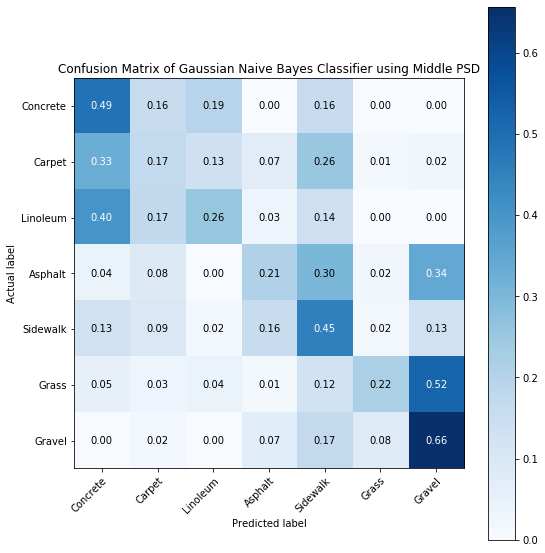

In [160]:
plot_confusion_matrix(test_psd_log[1]['Middle'], predict_psd_log['Middle'], classes=terrains, normalize=True, 
                      title='Confusion Matrix of Gaussian Naive Bayes Classifier using Middle PSD')

In [161]:
#save_all_cm(test_vectors, predict_vectors, 'NB')

### Part (b) - k Nearest Neighbour

In [162]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=3)

In [163]:
predict_feat = predict_each_placement(train_feat, test_feat, model)
predict_fft = predict_each_placement(train_fft, test_fft, model)
predict_psd_log = predict_each_placement(train_psd_log, test_psd_log, model)

In [164]:
# Save as tuple of vectors
predict_vectors = (predict_feat, predict_fft, predict_psd_log)

In [165]:
# Compute accuracy by comparing predicted to actual labels
accuracy = accuracy_score(test_psd_log[1]['Middle'], predict_psd_log['Middle'])
print('Middle PSD k Nearest Neighbor Classifer: Accuracy = {}'.format(accuracy))

Middle PSD k Nearest Neighbor Classifer: Accuracy = 0.4818731117824773


In [166]:
update_accuracy_table(test_vectors, predict_vectors, 'k Nearest Neighbor')

<Figure size 432x288 with 0 Axes>

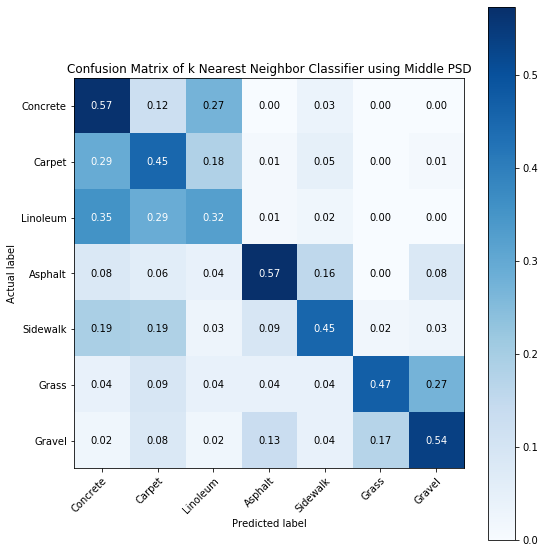

In [168]:
plot_confusion_matrix(test_psd_log[1]['Middle'], predict_psd_log['Middle'], classes=terrains, normalize=True, 
                      title='Confusion Matrix of k Nearest Neighbor Classifier using Middle PSD')

In [169]:
#save_all_cm(test_vectors, predict_vectors, 'kNN')

### Part (c) - Decision Trees

In [170]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier()

In [171]:
predict_feat = predict_each_placement(train_feat, test_feat, model)
predict_fft = predict_each_placement(train_fft, test_fft, model)
predict_psd_log = predict_each_placement(train_psd_log, test_psd_log, model)

In [172]:
# Save as tuple of vectors
predict_vectors = (predict_feat, predict_fft, predict_psd_log)

In [173]:
# Compute accuracy by comparing predicted to actual labels
accuracy = accuracy_score(test_psd_log[1]['Left'], predict_psd_log['Left'])
print('Right PSD Log Decision Tree Classifer: Accuracy = {}'.format(accuracy))

Right PSD Log Decision Tree Classifer: Accuracy = 0.3902439024390244


In [174]:
update_accuracy_table(test_vectors, predict_vectors, 'Decision Trees')

<Figure size 432x288 with 0 Axes>

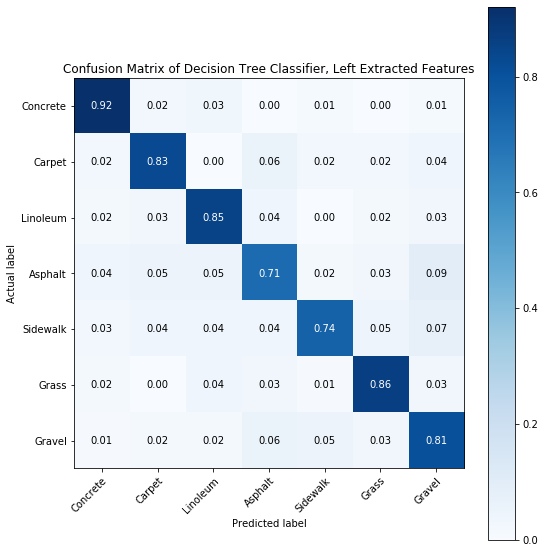

In [176]:
plot_confusion_matrix(test_feat[1]['Middle'], predict_feat['Middle'], classes=terrains, normalize=True, 
                      title='Confusion Matrix of Decision Tree Classifier, Left Extracted Features')

In [177]:
#save_all_cm(test_vectors, predict_vectors, 'DT')

### Part (d) - Random Forest 

In [178]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()

In [179]:
predict_feat = predict_each_placement(train_feat, test_feat, model)
predict_fft = predict_each_placement(train_fft, test_fft, model)
predict_psd_log = predict_each_placement(train_psd_log, test_psd_log, model)

/home/caris/anaconda2/envs/keenanm/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [180]:
# Save as tuple of vectors
predict_vectors = (predict_feat, predict_fft, predict_psd_log)

In [181]:
# Compute accuracy by comparing predicted to actual labels
accuracy = accuracy_score(test_psd_log[1]['Middle'], predict_psd_log['Middle'])
print('Right PSD Log Random Forest Classifer: Accuracy = {}'.format(accuracy))

Right PSD Log Random Forest Classifer: Accuracy = 0.6057401812688822


In [182]:
update_accuracy_table(test_vectors, predict_vectors, 'Random Forest')

<Figure size 432x288 with 0 Axes>

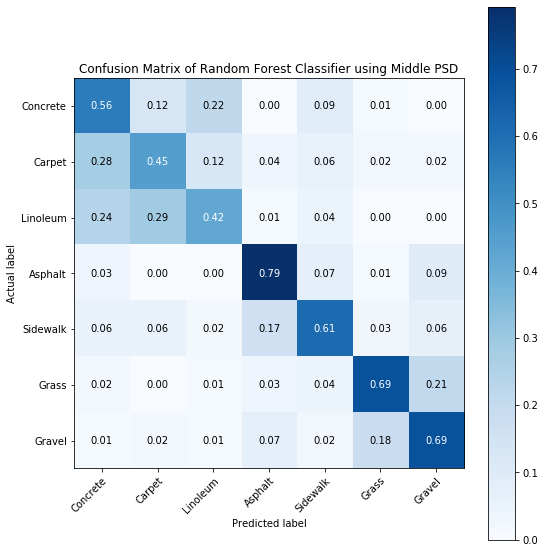

In [184]:
plot_confusion_matrix(test_psd_log[1]['Middle'], predict_psd_log['Middle'], classes=terrains, normalize=True, 
                      title='Confusion Matrix of Random Forest Classifier using Middle PSD')

In [185]:
#save_all_cm(test_vectors, predict_vectors, 'RF')

### Part (e) - AdaBoost

In [186]:
from sklearn.ensemble import AdaBoostClassifier
model = AdaBoostClassifier()

In [187]:
predict_feat = predict_each_placement(train_feat, test_feat, model)
predict_fft = predict_each_placement(train_fft, test_fft, model)
predict_psd_log = predict_each_placement(train_psd_log, test_psd_log, model)

In [188]:
# Save as tuple of vectors
predict_vectors = (predict_feat, predict_fft, predict_psd_log)

In [189]:
# Compute accuracy by comparing predicted to actual labels
accuracy = accuracy_score(test_psd_log[1]['Middle'], predict_psd_log['Middle'])
print('Right PSD Log AdaBoost Classifer: Accuracy = {}'.format(accuracy))

Right PSD Log AdaBoost Classifer: Accuracy = 0.5060422960725075


In [190]:
update_accuracy_table(test_vectors, predict_vectors, 'AdaBoost')

<Figure size 432x288 with 0 Axes>

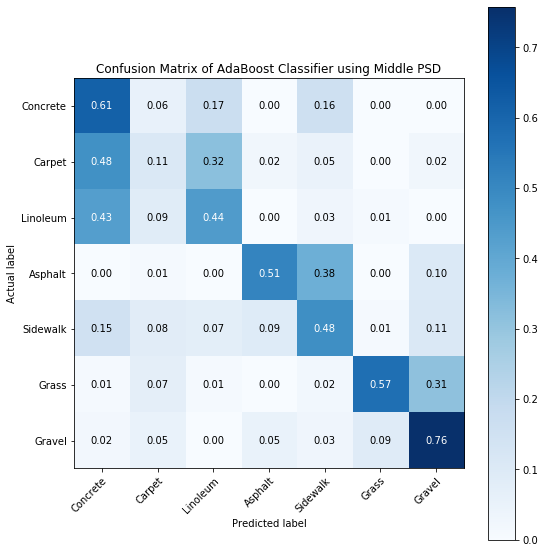

In [192]:
plot_confusion_matrix(test_psd_log[1]['Middle'], predict_psd_log['Middle'], classes=terrains, normalize=True, 
                      title='Confusion Matrix of AdaBoost Classifier using Middle PSD')

In [193]:
#save_all_cm(test_vectors, predict_vectors, 'AB')

### Part (f) - SVM (Support Vector Machine)

In [194]:
from sklearn.svm import SVC
model = SVC()

In [195]:
# Predict for each of our feature vectors
predict_feat = predict_each_placement(train_feat, test_feat, model)
predict_fft = predict_each_placement(train_fft, test_fft, model)
predict_psd_log = predict_each_placement(train_psd_log, test_psd_log, model)

/home/caris/anaconda2/envs/keenanm/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/caris/anaconda2/envs/keenanm/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/caris/anaconda2/envs/keenanm/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/caris/anacond

In [196]:
# Save as tuple of vectors
predict_vectors = (predict_feat, predict_fft, predict_psd_log)

In [197]:
# Compute accuracy by comparing predicted to actual labels
accuracy = accuracy_score(test_psd_log[1]['Middle'], predict_psd_log['Middle'])
print('Middle PSD SVM Classifer: Accuracy = {}'.format(accuracy))

Middle PSD SVM Classifer: Accuracy = 0.7099697885196374


In [198]:
update_accuracy_table(test_vectors, predict_vectors, 'Support Vector Machine')

In [199]:
accuracy_table

,Vector,Naive Bayes,k Nearest Neighbor,Decision Trees,Random Forest,AdaBoost,Support Vector Machine
0,Middle ExtractedFeatures,0.080060,0.312689,0.814199,0.522659,0.421450,0.419940
1,Left ExtractedFeatures,0.142857,0.278746,0.905923,0.804878,0.498258,0.334495
2,Right ExtractedFeatures,0.101045,0.247387,0.947735,0.825784,0.536585,0.254355
3,Middle FFT,0.438066,0.604230,0.536254,0.619335,0.493958,0.287009
4,Left FFT,0.369338,0.250871,0.428571,0.487805,0.421603,0.195122
5,Right FFT,0.320557,0.233449,0.463415,0.494774,0.365854,0.216028
6,Middle PSDLog,0.356495,0.481873,0.498489,0.605740,0.506042,0.709970
7,Left PSDLog,0.303136,0.303136,0.390244,0.456446,0.386760,0.480836
8,Right PSDLog,0.376307,0.310105,0.397213,0.442509,0.358885,0.470383


<Figure size 432x288 with 0 Axes>

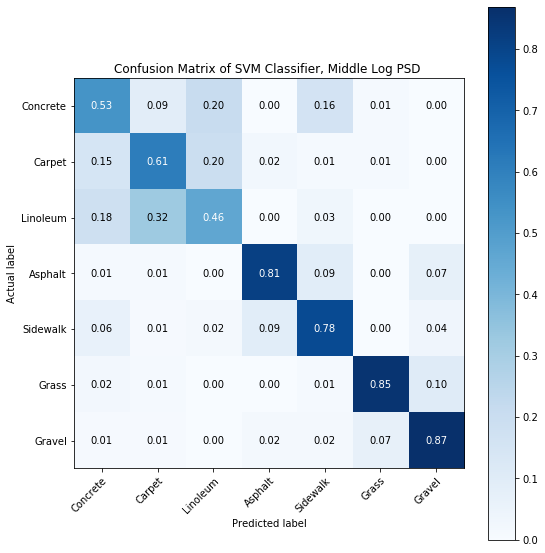

In [200]:
plot_confusion_matrix(test_psd_log[1]['Middle'], predict_psd_log['Middle'], classes=terrains, normalize=True, 
                      title='Confusion Matrix of SVM Classifier, Middle Log PSD ')

In [201]:
#save_all_cm(test_vectors, predict_vectors, 'SVM')

## Part 10 - Comparing Controlled Datasets

### Part (a) - Powered vs Manual Wheelchair Dataset

#### Part (i) - Powered Wheelchair

In [202]:
model = SVC()

In [203]:
# Extract train and test from each set of features
train_feat_power, test_feat_power = extract_train_test(feat_combined_power)
train_fft_power, test_fft_power = extract_train_test(fft_combined_power)
train_psd_log_power, test_psd_log_power = extract_train_test(psd_log_combined_power)

In [204]:
predict_feat_power = predict_each_placement(train_feat_power, test_feat_power, model)
predict_fft_power = predict_each_placement(train_fft_power, test_fft_power, model)
predict_psd_log_power = predict_each_placement(train_psd_log_power, test_psd_log_power, model)

/home/caris/anaconda2/envs/keenanm/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/caris/anaconda2/envs/keenanm/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/caris/anaconda2/envs/keenanm/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [205]:
# Compute accuracy by comparing predicted to actual labels
accuracy = accuracy_score(test_psd_log_power[1]['Middle'], predict_psd_log_power['Middle'])
print('Middle Powered PSD SVM Classifer: Accuracy = {}'.format(accuracy))

Middle Powered PSD SVM Classifer: Accuracy = 0.7988668555240793


<Figure size 432x288 with 0 Axes>

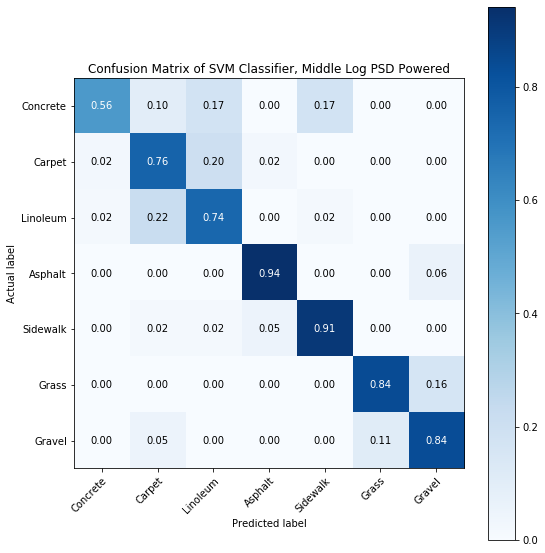

In [206]:
plot_confusion_matrix(test_psd_log_power[1]['Middle'], predict_psd_log_power['Middle'], 
                      classes=terrains, normalize=True, 
                      title='Confusion Matrix of SVM Classifier, Middle Log PSD Powered')

In [207]:
#save_all_cm(test_vectors_power, predict_vectors_power, 'SVM', save_tag='Power')

#### Part (ii) - Manual Wheelchair

In [208]:
# Extract train and test from each set of features
train_feat_manual, test_feat_manual = extract_train_test(feat_combined_manual)
train_fft_manual, test_fft_manual = extract_train_test(fft_combined_manual)
train_psd_log_manual, test_psd_log_manual = extract_train_test(psd_log_combined_manual)

In [209]:
predict_feat_manual = predict_each_placement(train_feat_manual, test_feat_manual, model)
predict_fft_manual = predict_each_placement(train_fft_manual, test_fft_manual, model)
predict_psd_log_manual = predict_each_placement(train_psd_log_manual, test_psd_log_manual, model)

/home/caris/anaconda2/envs/keenanm/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/caris/anaconda2/envs/keenanm/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/caris/anaconda2/envs/keenanm/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/caris/anacond

In [210]:
# Compute accuracy by comparing predicted to actual labels
accuracy = accuracy_score(test_psd_log_manual[1]['Middle'], predict_psd_log_manual['Middle'])
print('Middle Powered PSD SVM Classifer: Accuracy = {}'.format(accuracy))

Middle Powered PSD SVM Classifer: Accuracy = 0.6375404530744336


<Figure size 432x288 with 0 Axes>

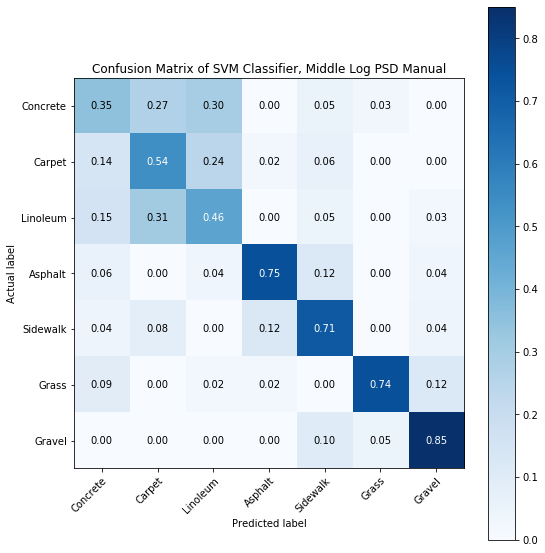

In [211]:
plot_confusion_matrix(test_psd_log_manual[1]['Middle'], predict_psd_log_manual['Middle'], 
                      classes=terrains, normalize=True, 
                      title='Confusion Matrix of SVM Classifier, Middle Log PSD Manual')

In [212]:
#save_all_cm(test_vectors_manual, predict_vectors_manual, 'SVM', save_tag='Manual')

### Part (b) - Comparing Movement Datasets

#### Part (i) - Donut Movement

In [213]:
# Extract train and test from each set of features
train_feat_donut, test_feat_donut = extract_train_test(feat_combined_donut)
train_fft_donut, test_fft_donut = extract_train_test(fft_combined_donut)
train_psd_log_donut, test_psd_log_donut = extract_train_test(psd_log_combined_donut)

In [214]:
predict_feat_donut = predict_each_placement(train_feat_donut, test_feat_donut, model)
predict_fft_donut = predict_each_placement(train_fft_donut, test_fft_donut, model)
predict_psd_log_donut = predict_each_placement(train_psd_log_donut, test_psd_log_donut, model)

/home/caris/anaconda2/envs/keenanm/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/caris/anaconda2/envs/keenanm/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/caris/anaconda2/envs/keenanm/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/caris/anacond

<Figure size 432x288 with 0 Axes>

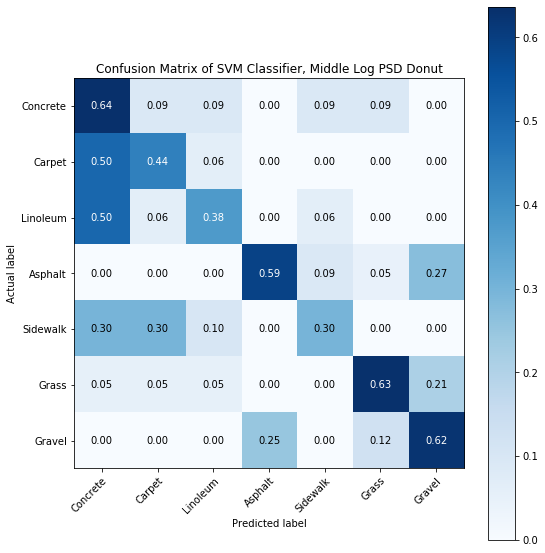

In [215]:
plot_confusion_matrix(test_psd_log_donut[1]['Middle'], predict_psd_log_donut['Middle'], 
                      classes=terrains, normalize=True, 
                      title='Confusion Matrix of SVM Classifier, Middle Log PSD Donut')

#### Part (ii) - Straight Movement

In [216]:
# Extract train and test from each set of features
train_feat_straight, test_feat_straight = extract_train_test(feat_combined_straight)
train_fft_straight, test_fft_straight = extract_train_test(fft_combined_straight)
train_psd_log_straight, test_psd_log_straight = extract_train_test(psd_log_combined_straight)

In [217]:
predict_feat_straight = predict_each_placement(train_feat_straight, test_feat_straight, model)
predict_fft_straight = predict_each_placement(train_fft_straight, test_fft_straight, model)
predict_psd_log_straight = predict_each_placement(train_psd_log_straight, test_psd_log_straight, model)

/home/caris/anaconda2/envs/keenanm/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/caris/anaconda2/envs/keenanm/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/caris/anaconda2/envs/keenanm/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/caris/anacond

<Figure size 432x288 with 0 Axes>

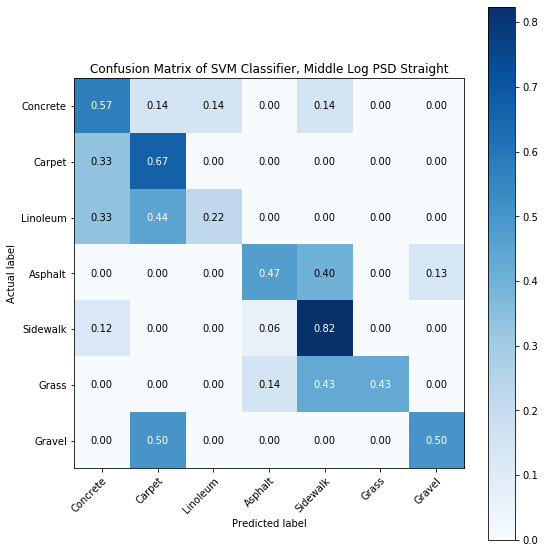

In [218]:
plot_confusion_matrix(test_psd_log_straight[1]['Middle'], predict_psd_log_straight['Middle'], 
                      classes=terrains, normalize=True, 
                      title='Confusion Matrix of SVM Classifier, Middle Log PSD Straight')

#### Part (iii) - Figure 8 Movement

In [219]:
# Extract train and test from each set of features
train_feat_figure, test_feat_figure = extract_train_test(feat_combined_figure)
train_fft_figure, test_fft_figure = extract_train_test(fft_combined_figure)
train_psd_log_figure, test_psd_log_figure = extract_train_test(psd_log_combined_figure)

In [220]:
predict_feat_figure = predict_each_placement(train_feat_figure, test_feat_figure, model)
predict_fft_figure = predict_each_placement(train_fft_figure, test_fft_figure, model)
predict_psd_log_figure = predict_each_placement(train_psd_log_figure, test_psd_log_figure, model)

/home/caris/anaconda2/envs/keenanm/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/caris/anaconda2/envs/keenanm/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/caris/anaconda2/envs/keenanm/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/caris/anacond

<Figure size 432x288 with 0 Axes>

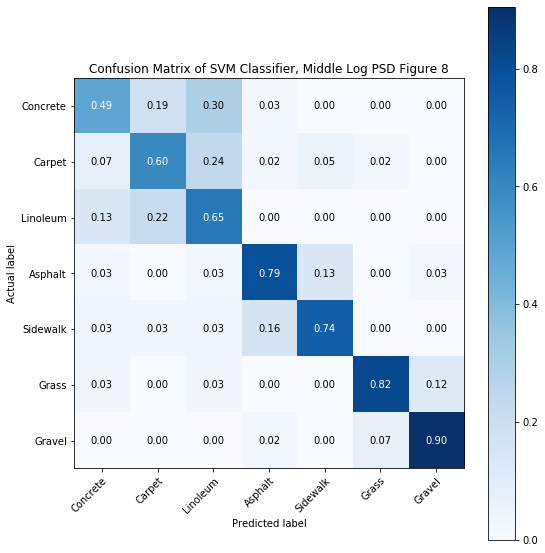

In [221]:
plot_confusion_matrix(test_psd_log_figure[1]['Middle'], predict_psd_log_figure['Middle'], 
                      classes=terrains, normalize=True, 
                      title='Confusion Matrix of SVM Classifier, Middle Log PSD Figure 8')

#### Part (iv) - Testing on Donut Movement with Classifier Trained on Figure 8 Movement 

In [222]:
predict_feat_donut2 = predict_each_placement(train_feat_figure, test_feat_donut, model)
predict_fft_donut2 = predict_each_placement(train_fft_figure, test_fft_donut, model)
predict_psd_log_donut2 = predict_each_placement(train_psd_log_figure, test_psd_log_donut, model)

/home/caris/anaconda2/envs/keenanm/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/caris/anaconda2/envs/keenanm/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/caris/anaconda2/envs/keenanm/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/caris/anacond

<Figure size 432x288 with 0 Axes>

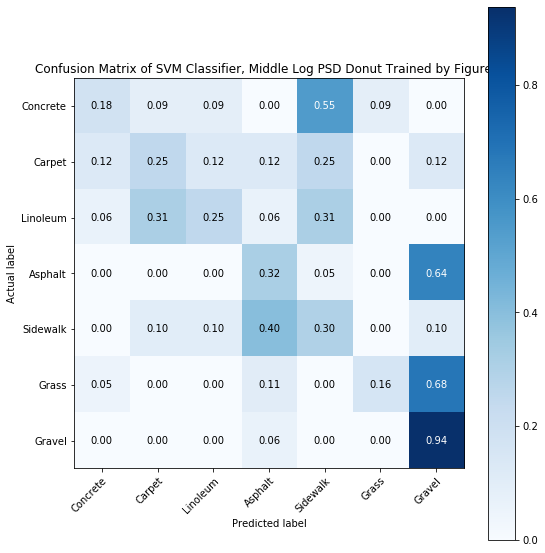

In [223]:
plot_confusion_matrix(test_psd_log_donut[1]['Middle'], predict_psd_log_donut2['Middle'], 
                      classes=terrains, normalize=True, 
                      title='Confusion Matrix of SVM Classifier, Middle Log PSD Donut Trained by Figure 8')

## Part 10 - Combining Feature Selection with Classifiers

In [224]:
def extract_top_features(combined_dataset, nfeats):
    combined_top_features = {}
    
    # Use mRMR to extract features from each placement
    for placement in placements:
        if placement in combined_dataset.keys():
            top_feats = pymrmr.mRMR(data=combined_dataset[placement], method='MID', nfeats=nfeats)
            # Always add label
            top_feats.append('Label')
            
        combined_top_features.update({placement: top_feats})
    
    return combined_top_features

In [225]:
def top_features_only(combined, top_features):
    combined_top = {}
    
    for placement in placements:
        combined_top.update({placement: combined[placement].loc[:, top_features[placement]]})
        
    return combined_top

### Part (a) - Feature Selection on Individual Feature Vectors

#### Part (i) - Extracted Features

In [226]:
model = DecisionTreeClassifier()

In [227]:
feat_top_features = extract_top_features(feat_combined, 10)

In [228]:
feat_combined_top = top_features_only(feat_combined, feat_top_features)
train_feat_top, test_feat_top = extract_train_test(feat_combined_top)
predict_feat_top = predict_each_placement(train_feat_top, test_feat_top, model)

In [229]:
# Compute accuracy by comparing predicted to actual labels
accuracy = accuracy_score(test_feat_top[1]['Left'], predict_feat_top['Left'])
print('DT Classifer with Top 10 Left Extracted Features: Accuracy = {}'.format(accuracy))

DT Classifer with Top 10 Left Extracted Features: Accuracy = 0.9512195121951219


<Figure size 432x288 with 0 Axes>

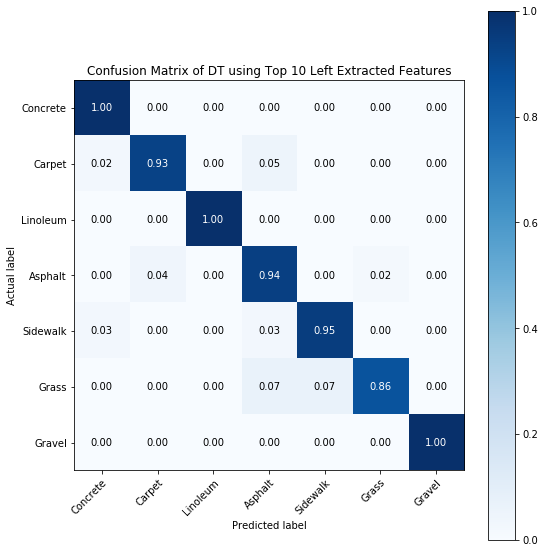

In [230]:
plot_confusion_matrix(test_feat_top[1]['Left'], predict_feat_top['Left'], 
                      classes=terrains, normalize=True, 
                      title='Confusion Matrix of DT using Top 10 Left Extracted Features')

#### Part (ii) - FFT

In [231]:
model = SVC()

In [232]:
fft_top_features = extract_top_features(fft_combined, 200)

In [233]:
fft_combined_top = top_features_only(fft_combined, fft_top_features)
train_fft_top, test_fft_top = extract_train_test(fft_combined_top)
predict_fft_top = predict_each_placement(train_fft_top, test_fft_top, model)

/home/caris/anaconda2/envs/keenanm/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/caris/anaconda2/envs/keenanm/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/caris/anaconda2/envs/keenanm/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [234]:
# Compute accuracy by comparing predicted to actual labels
accuracy = accuracy_score(test_fft_top[1]['Middle'], predict_fft_top['Middle'])
print('Middle SVM Classifer with Top 40 FFT Features: Accuracy = {}'.format(accuracy))

Middle SVM Classifer with Top 40 FFT Features: Accuracy = 0.4214501510574018


<Figure size 432x288 with 0 Axes>

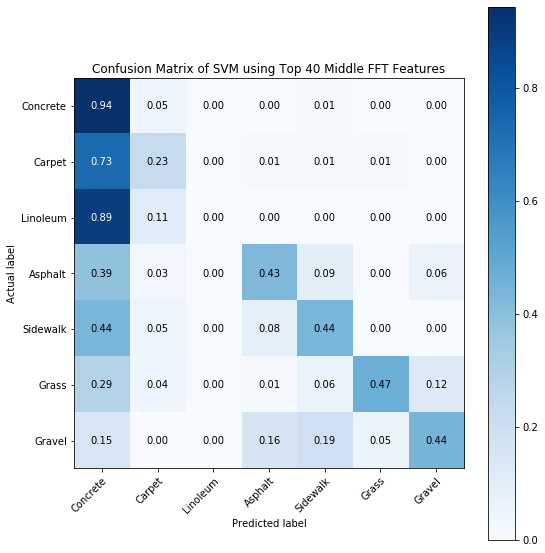

In [235]:
plot_confusion_matrix(test_fft_top[1]['Middle'], predict_fft_top['Middle'], 
                      classes=terrains, normalize=True, 
                      title='Confusion Matrix of SVM using Top 40 Middle FFT Features')

#### Part (iii) - PSD Log

In [236]:
psd_log_top_features = extract_top_features(psd_log_combined, 40)

In [237]:
psd_log_combined_top = top_features_only(psd_log_combined, psd_log_top_features)
train_psd_log_top, test_psd_log_top = extract_train_test(psd_log_combined_top)
predict_psd_log_top = predict_each_placement(train_psd_log_top, test_psd_log_top, model)

/home/caris/anaconda2/envs/keenanm/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/caris/anaconda2/envs/keenanm/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/caris/anaconda2/envs/keenanm/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [238]:
# Compute accuracy by comparing predicted to actual labels
accuracy = accuracy_score(test_psd_log_top[1]['Middle'], predict_psd_log_top['Middle'])
print('Middle SVM Classifer with Top 40 PSD Features: Accuracy = {}'.format(accuracy))

Middle SVM Classifer with Top 40 PSD Features: Accuracy = 0.6344410876132931


<Figure size 432x288 with 0 Axes>

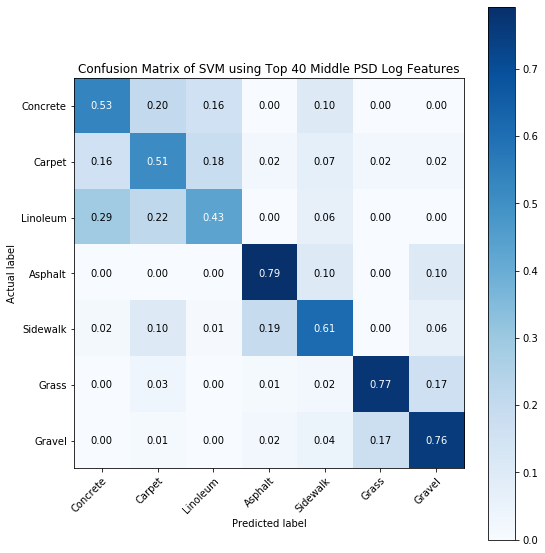

In [239]:
plot_confusion_matrix(test_psd_log_top[1]['Middle'], predict_psd_log_top['Middle'], 
                      classes=terrains, normalize=True, 
                      title='Confusion Matrix of SVM using Top 40 Middle PSD Log Features')

### Part (b) Compute mRMR up to Max Number of Features

In [240]:
feat_top_features = extract_top_features(feat_combined, 90)

In [241]:
feat_top_df = pd.DataFrame(feat_top_features, columns=['Left', 'Middle', 'Right'])
feat_top_df.head()

In [ ]:
feat_top_df.to_csv('processed_data/Top_Features.csv')

In [ ]:
fft_top_features = extract_top_features(fft_combined, 600)

In [ ]:
pd.DataFrame(fft_top_features, columns=['Left', 'Middle', 'Right']).to_csv('processed_data/Top_FFTs.csv')

In [ ]:
psd_log_top_features = extract_top_features(psd_log_combined, 600)

In [ ]:
pd.DataFrame(psd_log_top_features, columns=['Left', 'Middle', 'Right']).to_csv('processed_data/Top_PSDs.csv')

### Part (c) - Compare Top Features to Classification Accuracy

In [ ]:
def subset_top(top_features, n_top):
    subset_top_features = {}
    
    for placement, features in top_features.items():
        n_features = features[0:n_top - 1]
        # Add label to ensure it remains with the data
        if 'Label' not in n_features:
            n_features.append('Label')
        
        subset_top_features.update({placement: n_features})
        
    return subset_top_features

In [ ]:
def train_n_feats(combined, top_features):
    n_feats_arr = np.arange(5, len(top_features['Middle']), 5)
    accuracies = {'Middle': [], 'Left': [], 'Right': []}

    # Train and test for each number of top features
    for n_feat in n_feats_arr:
        combined_top = top_features_only(combined, subset_top(top_features, n_feat))
        train_feat_top, test_feat_top = extract_train_test(combined_top)
        predict_feat_top = predict_each_placement(train_feat_top, test_feat_top, model)

        # Compare accuracies vs top features
        for placement in test_feat_top[1].keys():
            accuracies[placement].append(accuracy_score(test_feat_top[1][placement], 
                                                          predict_feat_top[placement]))

    return n_feats_arr, accuracies

#### Part (i) - Compare Feature Vectors of each Placement for Same Classifier

In [ ]:
model = DecisionTreeClassifier()

In [ ]:
feat_n_features, feat_accuracies = train_n_feats(feat_combined, feat_top_features)

In [ ]:
fft_n_features, fft_accuracies = train_n_feats(fft_combined, fft_top_features)

In [ ]:
psd_log_n_features, psd_log_accuracies = train_n_feats(psd_log_combined, psd_log_top_features)

In [ ]:
def plot_n_features_accuracy(n_features, accuracies, feat_name=None, classifier_name=None):
    plt.clf()
    plt.figure(figsize=(8, 6))
    
    for placement, accuracy in accuracies.items():
        plt.plot(n_features, accuracy, label=placement)
        
    plt.ylabel('Accuracy (%)')
    plt.xlabel('Top Features Used')
    plt.title('Accuracy vs Top ' + feat_name + ', Classifier = ' + classifier_name)
    plt.legend()
    plt.show()

In [ ]:
plot_n_features_accuracy(feat_n_features, feat_accuracies, 'Extracted Features', 'DT')

#### Part (ii) - Compare Classifiers for Same Placement and Feature Vector

In [ ]:
# Dictionary of accuracy vs number of features for each classifier
classifiers_n_features = {}

In [ ]:
classifiers = {'Decision Tree': DecisionTreeClassifier(), 'Random Forest': RandomForestClassifier(),
               'Support Vector Machine': SVC()}

for classifier_name, classifier in classifiers.items():
    feat = train_n_feats(feat_combined, feat_top_features)
    fft = train_n_feats(fft_combined, fft_top_features)
    psd_log = train_n_feats(psd_log_combined, psd_log_top_features)
    
    classifiers_n_features.update({classifier_name: (feat, fft, psd_log)})

In [ ]:
def plot_classifiers_vs_n_features(vector_num, placement):
    plt.clf()
    plt.figure(figsize=(10, 8))
    
    for class_name, class_vectors  in classifiers_n_features.items():
        (n_features, accuracy) = class_vectors[vector_num]
        
        # If we want to plot all the placements
        if placement == 'All':
            for _placement in placements:
                if _placement in accuracy.keys():
                    plt.plot(n_features, accuracy[_placement], label=class_name + ' ' + _placement)
        else:
            plt.plot(n_features, accuracy[placement], label=class_name)
    
    plt.xlabel('Top Features Used')
    plt.ylabel('Accuracy (%)')
    plt.title('Accuracy vs Top Features for ' + placement + ' ' + vector_names[vector_num])
    plt.legend()
    plt.show()

In [ ]:
plot_classifiers_vs_n_features(0, 'All')

In [ ]:
plot_classifiers_vs_n_features(1, 'All')

In [ ]:
plot_classifiers_vs_n_features(2, 'All')

#### Part (iii) - Confusion Matrices for Same Classifier and Feature Vector

In [ ]:
feat_top_features_10 = extract_top_features(feat_combined, 10)
feat_top_features_5 = extract_top_features(feat_combined, 5)
feat_top_features_1 = extract_top_features(feat_combined, 1)

In [ ]:
feat_combined_top = top_features_only(feat_combined, feat_top_features_10)
train_feat_top, test_feat_top = extract_train_test(feat_combined_top)
predict_feat_top = predict_each_placement(train_feat_top, test_feat_top, model)

In [ ]:
# Compute accuracy by comparing predicted to actual labels
accuracy = accuracy_score(test_feat_top[1]['Left'], predict_feat_top['Left'])
print('DT Classifer with Top 10 Left Extracted Features: Accuracy = {}'.format(accuracy))

In [ ]:
plot_confusion_matrix(test_feat_top[1]['Left'], predict_feat_top['Left'], 
                      classes=terrains, normalize=True, 
                      title='Confusion Matrix of DT using Top 10 Left Extracted Features')

In [ ]:
feat_combined_top = top_features_only(feat_combined, feat_top_features_5)
train_feat_top, test_feat_top = extract_train_test(feat_combined_top)
predict_feat_top = predict_each_placement(train_feat_top, test_feat_top, model)

In [ ]:
# Compute accuracy by comparing predicted to actual labels
accuracy = accuracy_score(test_feat_top[1]['Left'], predict_feat_top['Left'])
print('DT Classifer with Top 5 Left Extracted Features: Accuracy = {}'.format(accuracy))

In [ ]:
plot_confusion_matrix(test_feat_top[1]['Left'], predict_feat_top['Left'], 
                      classes=terrains, normalize=True, 
                      title='Confusion Matrix of DT using Top 5 Left Extracted Features')

In [ ]:
feat_combined_top = top_features_only(feat_combined, feat_top_features_1)
train_feat_top, test_feat_top = extract_train_test(feat_combined_top)
predict_feat_top = predict_each_placement(train_feat_top, test_feat_top, model)

In [ ]:
# Compute accuracy by comparing predicted to actual labels
accuracy = accuracy_score(test_feat_top[1]['Left'], predict_feat_top['Left'])
print('DT Classifer with Top 1 Left Extracted Features: Accuracy = {}'.format(accuracy))

In [ ]:
plot_confusion_matrix(test_feat_top[1]['Left'], predict_feat_top['Left'], 
                      classes=terrains, normalize=True, 
                      title='Confusion Matrix of DT using Top 1 Left Extracted Features')

### Glossary

`Dataset` - Batch of data recorded on one terrain type

`Data Window` - Split up portion of a `Dataset`

`Direction` - Linear acceleration or gyroscope in $x,y$ or $z$

`Feature Vector` - Any feature of the data that can be used to classify terrain, e.g. Z Accel Mean, Y Accel FFT, etc

`Extracted Feature Vector` - Features that aren't from transforms, e.g. Z Accel Min, Y Accel Autocorrelation, etc

`Placement` - One of three IMU placements on the wheelchair, i.e. Middle, Left, or Right